# Postmating response in axenic and control _D. melanogaster_ females

Load packages and functions:

In [1]:
## Packages to load
req_packages = c("AnnotationHub", "AnnotationDbi", "Biobase", "circlize", "cluster", "clusterProfiler", "ComplexHeatmap", "cowplot", 
                 "cummeRbund" , "data.table", "DOSE", "EDASeq", "edgeR", "enrichplot", "gage", "genefilter", "ggpubr", 
                 "ggrepel", "ggthemes", "ggthemr", "Glimma", 
                 "GO.db", "goseq", "gplots", "grid", "gridExtra", "lattice", 
                 "imager", "org.Dm.eg.db", "pheatmap", "qvalue", "RColorBrewer", "RSkittleBrewer",
                 "reshape", "Rmisc", "RUVSeq","splitstackshape", "statmod", "stringr", "sva", "tidyverse",
                 "VennDiagram", "viridis")
## load them, quietly
invisible(suppressWarnings(suppressMessages(
    lapply(req_packages, require, character.only = TRUE)
)))

## The Cowplot package changes the default themes of ggplot2. Set the bw theme with larger font sizes like so:
theme_set(theme_bw(base_size = 16))
## ... or set the default theme
# theme_set(theme_gray())

## suppress excessive VennDiagram log files
futile.logger::flog.threshold(futile.logger::ERROR, name = "VennDiagramLogger")

NULL

Load custom functions:

In [2]:
source("Functions.R")

Some raw files need to be processed to produce auxiliary files needed below. Running a script in the "Misc" folder should do it:

In [3]:
# system('./Misc/initial_file_modifications.sh')

Load the FlyAtlas2 expression data:

In [4]:
tpm.table_fa2 = read.csv("Annotoations/FlyAtlas2_TPM_table.txt", header = T, sep = "\t")
tpm.matrix_fa2 = read.csv("Annotoations/FlyAtlas2_meanTPM_table.txt", header = T, sep = "\t", row.names = 1)

Calculate tao for a select subset of female tissue:

In [5]:
desired_fa2_columns = c("Female_Anal_Pad", "Female_Crop", "Female_Salivary_Gland", "Female_Midgut", "Female_Hindgut",
                           "Female_Tubule", "Female_Brain", "Female_Eye", "Female_Head",
                           "Female_Thoracicoabdominal_Ganglion", "Female_Virgin_Spermatheca",
                           "Female_Mated_Spermatheca", "Ovary", "Female_Carcass")
tpm.matrix_fa2.female_tissues = subset(tpm.matrix_fa2, select = desired_fa2_columns)
fem_tao = suppressWarnings(as.data.frame(calcSpecificity(matrix = tpm.matrix_fa2.female_tissues, pseudocount = 1)))

Make another matrix that includes the female whole body sample:

In [6]:
tpm.matrix_fa2.female = subset(tpm.matrix_fa2, select = c(desired_fa2_columns, 'Female_whole_flies'))

... and the associated sample information:

In [7]:
sample.info = read.table("Misc/SraRunTable_FlyAtlas2_modified.txt", header = T, sep = "\t")
sample.info = filter(sample.info, RNA == "mRNA")
sample.info = select(sample.info, Library_Name, Replicate_Name, Sex, dev_stage, organism_part, Sample_Name)
sample.info$Library_Name = gsub("Female ", "", sample.info$Library_Name)
sample.info$Library_Name = gsub("Male ", "", sample.info$Library_Name)
sample.info$Library_Name = gsub("Larval ", "", sample.info$Library_Name)
sample.info$Sex = gsub("NA", "unknown", sample.info$Sex)

Load read count data:

In [8]:
baseCounts = read.table("eXpress/express.gene.counts.matrix", header=T, row.names=1, com='', check.names=F)
counts_bt2 = baseCounts
colnames(counts_bt2) = gsub("O", "", colnames(counts_bt2))

Load annotation files:

In [9]:
annotation = read.csv("Annotoations/fbgn_annotation_ID_fb_2018_04_mod.tsv", header = T, check.names = F, sep ="\t")

Load the gene snapshot data:

In [10]:
snapshots = read.csv("Annotoations/gene_snapshots_fb_2018_05.tsv", header = T, sep ="\t", quote = "")

Load the Uniprot IDs:

In [11]:
aux_IDs = read.csv("Annotoations/fbgn_auxiliary_ids.txt", header = T, sep ="\t", na.string = "")

Load the GO information for GOseq (if we use it):

In [12]:
GO_associations = read.csv("Annotoations/GO_associaations.fb", header = T, sep ="\t")
GO_info = aggregate(term~FBgn_ID, data = GO_associations, toString)
rownames(GO_info) = GO_info$FBgn_ID
GO_info = subset(GO_info, select = "term")
GO_info$term = gsub(", ", ",", GO_info$term)

To perform GO analyses with clusterProfiler, we need to obtain the EntrezIDs:

In [13]:
melAnnDb <- org.Dm.egFLYBASE
mapped_IDs <- mappedkeys(melAnnDb)
as.list(melAnnDb[mapped_IDs]) %>% unlist() %>% as.data.frame() -> Entrez_mappings
Entrez_mappings$ent_id = rownames(Entrez_mappings)
as_tibble(Entrez_mappings) %>% rename(FBgn_ID = ".") -> Entrez_mappings

Load the known immunity genes from Sackton *et al* 2008:

In [14]:
immunity_genes.df = read.csv("Annotoations/mel_immunity_genes.txt", header = T, sep = "\t", check.names = F)
immunity_genes = as.character(immunity_genes.df$FlyBaseID)

Load the transcript lengths for the eXpress data:

In [15]:
bt2_trans_lengths = read.csv("eXpress/transcriptome/transcript_lengths.txt", header = T, sep = "\t")

Load the gene-to-transcript mapping:

In [16]:
gene_trans_map = read.table("eXpress/transcriptome/dmel-all-transcript-r6.23.gene_trans_map", header = F, sep = "\t")
colnames(gene_trans_map) = c("gene_id", "transcript_id")

Generate a gene length object for the eXpress data:

In [17]:
# Merge transcript length file with gene-to-trans file:
tmpMrge = merge(bt2_trans_lengths, gene_trans_map)
# Select only the length and gene_id columns
tmpMrge = as.data.table(subset(tmpMrge, select = c("length", "gene_id")))
# For each gene ID entry, select the entry with largest value in the "length" column:
bt2_gene_lengths = as.data.frame(tmpMrge[tmpMrge[, .I[which.max(length)], by=gene_id]$V1])
# assign gene names to rownames
rownames(bt2_gene_lengths) <- bt2_gene_lengths$gene_id
# # select the length column only
bt2_gene_lengths = subset(bt2_gene_lengths, select = "length")
# remove un-needed intermediate objects
rm(tmpMrge)

For GO analyses we need to create a couple of objects:

In [18]:
GO_info_listed = apply(GO_info, 1, function(x) unlist(strsplit(x,',')))
names(GO_info_listed) = rownames(GO_info)
features_with_GO = rownames(GO_info)
lengths_features_with_GO = bt2_gene_lengths[features_with_GO,]

Generate sample info object:

In [19]:
sampleData = read.table("Misc/samples.txt", header = F, check.names = F, fill = T)
sampleInfo = sampleData
colnames(sampleInfo) = c("Sample", "Replicate")

sampleInfo$Female = ifelse(grepl("^A",sampleInfo$Sample), "axenic", "control")

sampleInfo$Male = ifelse(grepl("A$", sampleInfo$Sample), "axenic", ifelse(grepl("C$", sampleInfo$Sample), "control", "none"))

sampleInfo$Handler = ifelse(grepl("3|4", sampleInfo$Replicate), "Yasir", "Sofie")

sampleInfo$Status = ifelse(grepl("none", sampleInfo$Male), "virgin", "mated")

sampleInfo$Sample = gsub("O", "", sampleInfo$Sample)
sampleInfo$Replicate = gsub("O", "", sampleInfo$Replicate)
SampleInfo = sampleInfo

Generate a TPM table from the counts. Use any arbitrary number for lengths since this is 3prime data:

In [20]:
tpm_bt2 <- apply(counts_bt2, 2, function(x) tpm(x, 2000))

Reshape the TPM matrix to calculate means and generate heatmaps and individual gene plots later:

In [21]:
tmp.tpmMatrix<-tpm_bt2
# colnames(tmp.tpmMatrix) <- sampleInfo$Sample
tmp.tpmMatrix.m <- as.data.frame(melt(as.matrix(tmp.tpmMatrix)))
colnames(tmp.tpmMatrix.m) <- c("gene_id", "replicate", "TPM")
tmp.tpmMatrix.m <- merge(tmp.tpmMatrix.m, sampleInfo, by.x = "replicate", by.y = "Replicate", all.x = T)
tmp.tpmMatrix.m$replicate = gsub(".*_", "", tmp.tpmMatrix.m$replicate)
annot.sub = subset(annotation, select = c("primary_FBgn", "gene_symbol", "annotation_ID"))
tmp.tpmMatrix.m = merge(tmp.tpmMatrix.m, annot.sub, by.x = "gene_id", by.y = "primary_FBgn", all.x = T)
# tmp.tpmMatrix.m = merge
tpm.table = tmp.tpmMatrix.m
tpm.table$Male = factor(tpm.table$Male, levels = c("none", "axenic", "control"))
tpm.table$Status = factor(tpm.table$Status, levels = c("virgin", "mated"))
rm(tmp.tpmMatrix.m)

We'll make a mean TPM matrix:

In [22]:
# tpmSE = summarySE(tpm.table, measurevar = "TPM", groupvars = c("gene_id", "Sample", "Female", "Male", "Handler", "Status", "gene_symbol", "annotation_ID"))

# write.table(tpmSE, "eXpress/tpmSE.txt", quote = F, sep = "\t", row.names = F)
tpmSE = read.table("eXpress/tpmSE.txt", header = T, sep = "\t")

tmpMat<-cast(tpmSE, gene_id~Sample, value ="TPM", fun.aggregate = mean)
tpmMatrix_mean <- tmpMat[,-1]
rownames(tpmMatrix_mean) <- tmpMat[,1]
rm(tmpMat)

the `geneBoxPlot` function can be used for single gene tpm boxplots of the data:

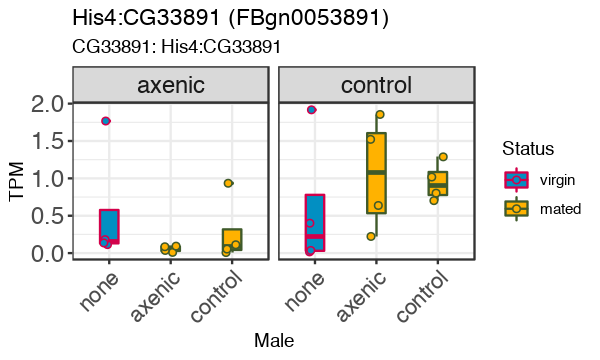

In [23]:
options(repr.plot.width = 5, repr.plot.height = 3)
geneBoxPlot_mon(tpmTable = tpm.table, "His4:CG33891", show_reps = F) + theme(axis.text.x = element_text(angle = 45, hjust = 1))

There's also a plotting function for the Fly Atlas data:

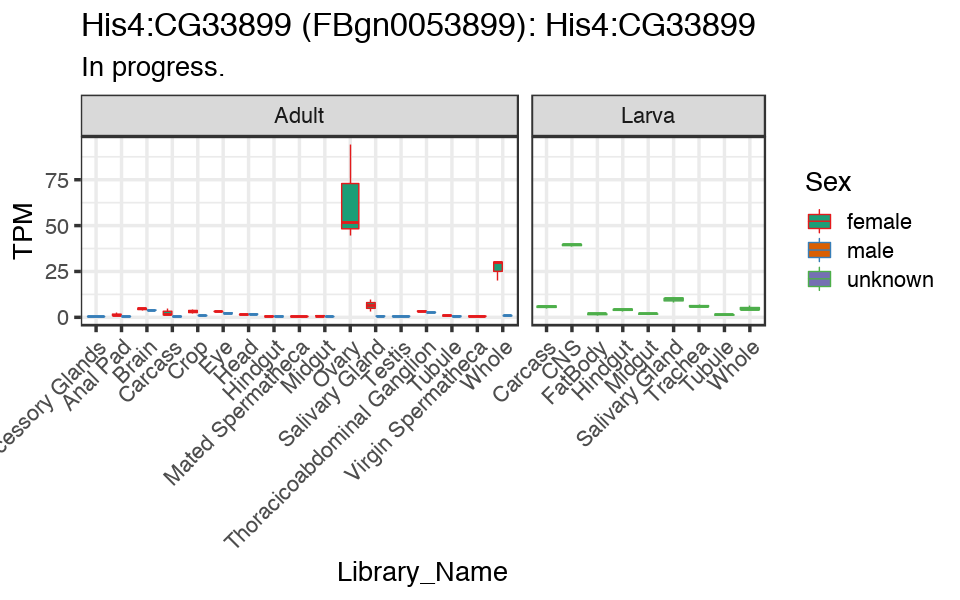

In [24]:
options(repr.plot.width = 8, repr.plot.height = 5)
geneBoxPlot_fa2(tpm.table_fa2, "His4:CG33899")

For heatmaps, we can make some modifications to the output format:

In [25]:
draw_colnames_45 <- function (coln, gaps, ...) {
    coord <- pheatmap:::find_coordinates(length(coln), gaps)
    x     <- coord$coord - 0.5 * coord$size
    res   <- grid::textGrob(
      coln, x = x, y = unit(1, "npc") - unit(3,"bigpts"),
      vjust = 0.75, hjust = 1, rot = 90, gp = grid::gpar(...)
    )
    return(res)
}
assignInNamespace(
  x = "draw_colnames",
  value = "draw_colnames_45",
  ns = asNamespace("pheatmap")
)

Output library size object:

In [26]:
LibSizes <- as.data.frame(colSums(counts_bt2))
libSizes <- cbind(sample = row.names(LibSizes), LibSizes)
row.names(libSizes)<- NULL
colnames(libSizes) = c("replicate", "counts")
libSizes$sample = gsub("_.*", "", libSizes$replicate)
libSizes$counts = round(libSizes$counts)

Make a barplot of library sizes:

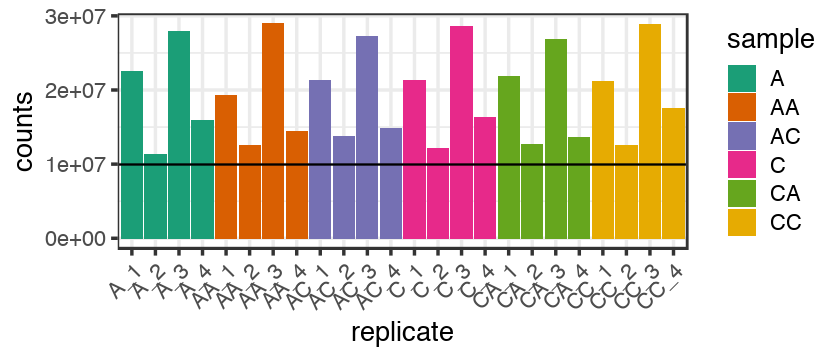

In [27]:
options(repr.plot.width = 7, repr.plot.height = 3)
# pdf("Figures/Library_sizes.pdf", width = 12, height = 4)
ggplot(libSizes, aes(replicate, counts, fill = sample)) + 
    geom_bar(stat="identity", position = "dodge") + 
#     theme_monokai_full() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
    geom_hline(yintercept = 10000000) +
    scale_fill_brewer(palette="Dark2") 
# dev.off()

## Fecundity analysis:

Warning message:
"Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session."


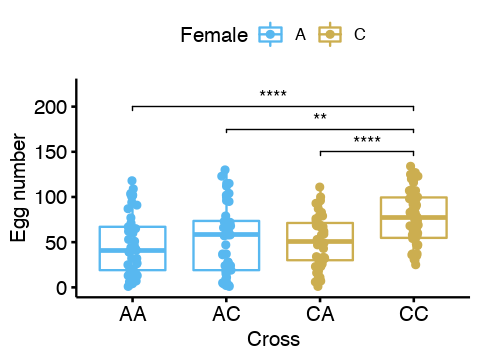

In [28]:
egg_counts <- read.csv("Fecundity-Hatchability/2019/Count_data.txt", header = T, sep = "\t")

my_comparisons <- list( c("AA", "CC"), c("AC", "CC"), c("CA", "CC") )

options(repr.plot.width = 4, repr.plot.height = 3)
ggboxplot(egg_counts, "Treatment", "Total",
    color = "Female", palette =c("#58b8f0","#ccae50"),
    add = "jitter") +
    stat_compare_means(comparisons = my_comparisons, label.y = c(200, 175, 150), aes(label = ..p.signif..), method = ) +
    scale_y_continuous(limits = c(0, 220)) +
    labs(x = "Cross", y = "Egg number")
# ggsave("Results/Figures/Fecundity_assay_boxJitter_plot.pdf", width = 4, height = 3)
# ggsave("Results/manuscript_figures/fecundity.pdf", width = 4, height = 3)

## Differential expression analysis:

First, filter out genes with very low expression from the counts matrix. We'll use a minimum cutoff of 1 CPM in at least 4 samples:

In [29]:
cpm_bt2 <- cpm(counts_bt2)
thresh_bt2 <- cpm_bt2 > 1
keep_bt2 <- rowSums(thresh_bt2) >= 4
countsKeep <- round(counts_bt2[keep_bt2,])
countsKeep_bt2 <- as.data.frame(lapply(countsKeep[1:24], as.integer))
rownames(countsKeep_bt2) <- rownames(countsKeep)
table(keep_bt2)

keep_bt2
FALSE  TRUE 
 6282  7649 

In [30]:
mm_genes <- rownames(subset(counts_bt2, duplicated(counts_bt2)))

Now define the groupings by sample and set up the design matrix:

In [31]:
groups = factor(sampleInfo$Sample)
batch = factor(sampleInfo$Handler)
design = model.matrix( ~ 0 + groups)
design_batch = model.matrix( ~ 0 + groups + batch)
colnames(design_batch) <- c(levels(groups), "batch")
rownames(design_batch) <- sampleInfo$Replicate
colnames(design) <- levels(groups)
rownames(design) <- sampleInfo$Replicate

Make an expression set to input for RUVseq:

In [32]:
set <- newSeqExpressionSet(as.matrix(countsKeep_bt2), phenoData = data.frame(groups, row.names = colnames(countsKeep_bt2)))
set <- betweenLaneNormalization(set, which="upper")

Now estimate the sources of uwanted variation using RUVseq:

In [33]:
y <- DGEList(counts=counts(set), group=groups)
y <- calcNormFactors(y, method="upperquartile")
y <- estimateDisp(y, design, robust = T)
fit <- glmQLFit(y, design, robust = T)
res <- residuals(fit, type="deviance")

Use the residual to estimate the factors of unwanted variation:

In [34]:
batch_ruv_res = RUVr(set,rownames(countsKeep_bt2),k=3,res)
RUVrNormalizedCounts = normCounts(object = batch_ruv_res)
rownames(RUVrNormalizedCounts) = rownames(countsKeep_bt2)

Let's make a new TPM table with the fixed counts:

In [35]:
tpm_bt2_fixed <- apply(RUVrNormalizedCounts, 2, function(x) tpm(x, 2000))

Reshape the TPM matrix to calculate means and generate heatmaps and individual gene plots later:

In [36]:
tmp.tpmMatrix<-tpm_bt2_fixed
# colnames(tmp.tpmMatrix) <- sampleInfo$Sample
tmp.tpmMatrix.m <- as.data.frame(melt(as.matrix(tmp.tpmMatrix)))
colnames(tmp.tpmMatrix.m) <- c("gene_id", "replicate", "TPM")
tmp.tpmMatrix.m <- merge(tmp.tpmMatrix.m, sampleInfo, by.x = "replicate", by.y = "Replicate", all.x = T)
tmp.tpmMatrix.m$replicate = gsub(".*_", "", tmp.tpmMatrix.m$replicate)
annot.sub = subset(annotation, select = c("primary_FBgn", "gene_symbol", "annotation_ID"))
tmp.tpmMatrix.m = merge(tmp.tpmMatrix.m, annot.sub, by.x = "gene_id", by.y = "primary_FBgn", all.x = T)
# tmp.tpmMatrix.m = merge
tpm.table.rc = tmp.tpmMatrix.m
tpm.table.rc$Male = factor(tpm.table.rc$Male, levels = c("none", "axenic", "control"))
tpm.table.rc$Status = factor(tpm.table.rc$Status, levels = c("virgin", "mated"))
rm(tmp.tpmMatrix.m)

Set up a new design matrix with the unwanted factors specified:

In [37]:
design_2 <- model.matrix(~ 0 + groups + W_1 + W_2 + W_3, data=pData(batch_ruv_res))
colnames(design_2) <- gsub("groups", "", colnames(design_2))

Create the DGElist object and GLM fit:

In [38]:
dgeList <- DGEList(counts = counts(set), group = groups)
dgeList <- calcNormFactors(dgeList, method="upperquartile")
dgeList <- estimateDisp(dgeList, design_2, robust = T)
dgeList_fit <- glmQLFit(dgeList, design_2, robust = T)
summary(dgeList$tagwise.dispersion)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000098 0.012268 0.021010 0.041909 0.036651 4.687418 

We'll make an FBgn-to-gene symbol object to append to the tTags tables:

In [39]:
FBgn_to_symbol = subset(annotation, select = c("gene_symbol", "primary_FBgn"))

Look at BCV and QQ plot:

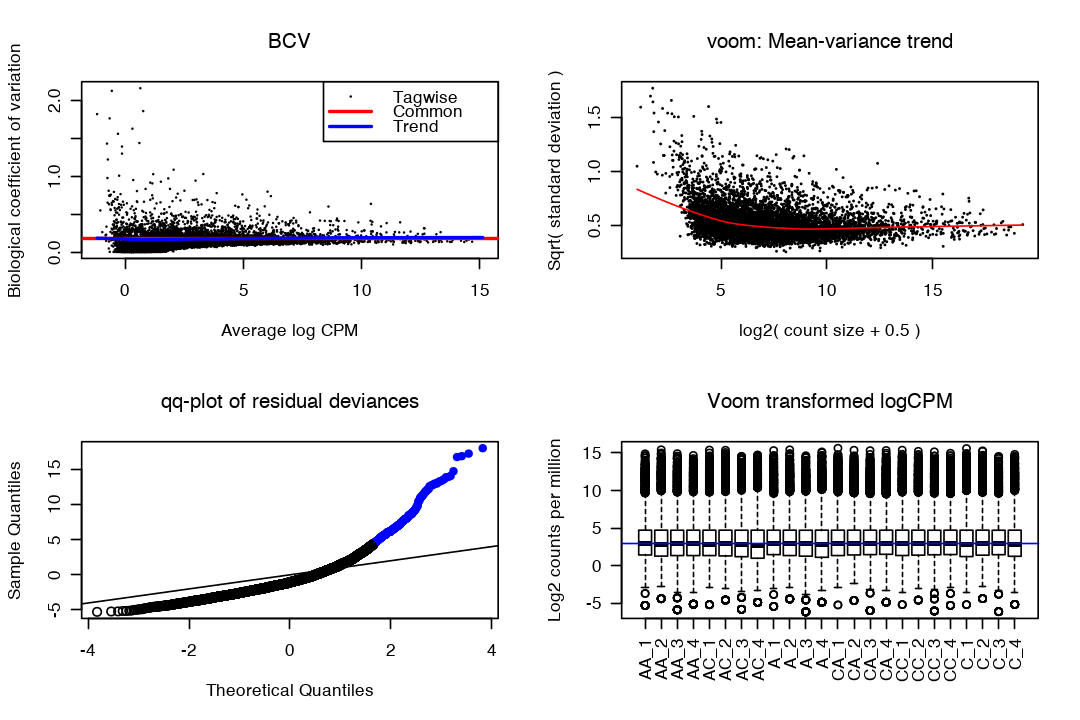

In [40]:
options(repr.plot.width = 9, repr.plot.height = 6)
par(mfrow=c(2,2))

# Biological coefficient of variation
plotBCV(dgeList, main = "BCV")

# mean-variance trend
voom = voom(dgeList, design_2, plot=TRUE)

# QQ-plot
gof(dgeList_fit, pcutoff = 0.05, adjust = "holm", plot = T)
# g.v <- gof(dgeList_fit, pcutoff = 0.05, adjust = "holm")
# z.v <- zscoreGamma(g.v$gof.statistics,shape=g.v$df/2,scale=2)
# qqnorm(z.v); qqline(z.v, col = 2,lwd=2,lty=2)

# log2 transformed and normalize boxplot of counts across samples
boxplot(voom$E, xlab="", ylab="Log2 counts per million",las=2,main="Voom transformed logCPM")
abline(h=median(voom$E),col="blue")

# rm(voom, g.v, z.v)


Generate a correlation plot between replicates:

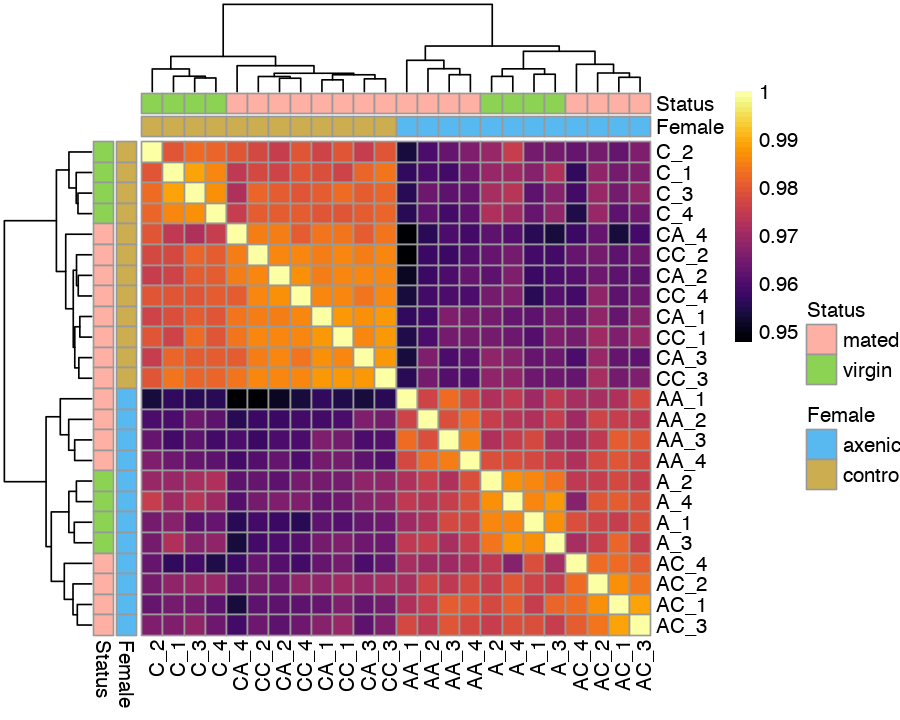

In [41]:
## Plot sample correlation
data = log2(RUVrNormalizedCounts+1)
# colnames(data) = gsub("Female_", "", colnames(data))
data = as.matrix(data)
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')

sampleColLabeling = sampleInfo
rownames(sampleColLabeling) = sampleColLabeling$Replicate
sampleColLabeling = subset(sampleColLabeling, select = c("Female", "Status"))

cor_colors <- list(Female = c("#58b8f0","#ccae50"), Status = c("#feb0a4","#8cd253"))
names(cor_colors$Female) <- unique(sampleColLabeling$Female)
names(cor_colors$Status) <- unique(sampleColLabeling$Status)

options(repr.plot.width = 7.5, repr.plot.height = 6)
pheatmap(
  mat               = sample_cor,
  color             = inferno(50),
#   border_color      = NA,
  show_colnames     = TRUE,
  show_rownames     = TRUE,
#     drop_levels       = TRUE,
    annotation_col    = sampleColLabeling,
  annotation_row    = sampleColLabeling,
  annotation_colors = cor_colors,
#   filename          = "Results/manuscript_figures/sample_correlations_all.pdf",
#   width             = 7.5, 
#   height            = 6,
  fontsize          = 12    
)
rm(data)
rm(sample_cor)

Hmmmm.... wierd groupings by replicate. Look at an MDS plot:

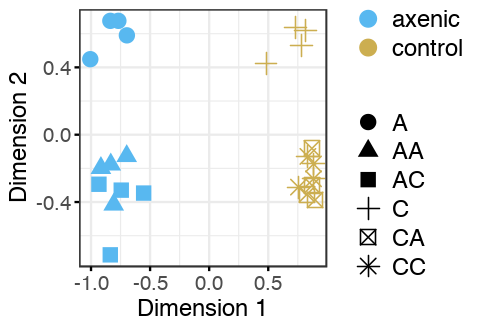

In [42]:
x <- DGEList(counts = RUVrNormalizedCounts, group = groups)
suppressWarnings(x <- calcNormFactors(x))
x <- estimateGLMCommonDisp(x, design)
x <- estimateGLMTagwiseDisp(x, design)
x <- estimateGLMTrendedDisp(x, design)

mdsObj <- plotMDS(x, plot = F)$cmdscale.out
    mdsObj <- as.data.frame(as.matrix(mdsObj))
    mdsObj$replicate <- rownames(mdsObj)
    colnames(mdsObj) = c("dim1", "dim2", "replicate")
    mdsObj = merge(mdsObj, sampleInfo, by.x = "replicate", by.y = "Replicate")
    mdsObj$replicate_num = gsub(".*_", "", mdsObj$replicate)

options(repr.plot.width = 4, repr.plot.height = 2.75)
        ggscatter(mdsObj, 
              x = "dim1", 
              y = "dim2",
              color = "Female",
              shape = "Sample",
              size = 4,
#               alpha = 0.8, 
              ggtheme = theme_bw(),
              repel = "Time",) + 
                theme(axis.text = element_text(size = 12), legend.title = element_blank(), axis.title = element_text(size = 14), legend.text = element_text(size = 14)) +
                labs ( x = "Dimension 1", y = "Dimension 2") +
             scale_color_manual(values = as.character(unlist(cor_colors$Female)))

ggsave("Results/manuscript_figures/MDS_plot.pdf", width = 4, height = 2.75)

We can look at the expression of individual genes across all our samples with barplots, e.g.:

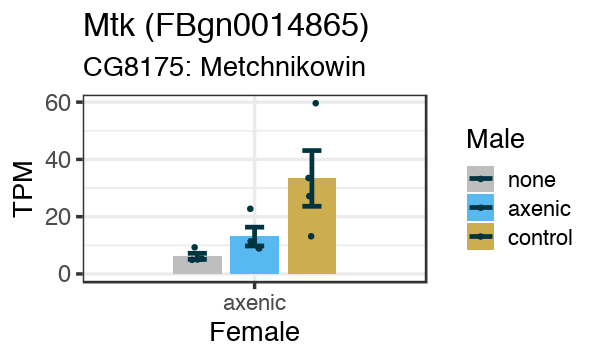

In [43]:
options(repr.plot.width = 5, repr.plot.height = 3)
myGene = "Mtk"
geneBarPlot_byFemale(tpmTable = tpm.table.rc, gene = myGene, show_reps = T)

### Contrast between virgin and mated control females:

Set up the contrasts:

In [44]:
CA.v.C_contrasts <- makeContrasts(CA-C, levels=design_2)
CC.v.C_contrasts <- makeContrasts(CC-C, levels=design_2)

Now let's look at the control females. First, females mated to axenic males

In [45]:
# run the LRT and extract the DE table
lrt.CA.v.C.table <- edge.DE(dgeList_fit, CA.v.C_contrasts, LRT = F)

CA.v.C_sigGenes = subset(lrt.CA.v.C.table, sig == "yes" & gene %!in% mm_genes)$gene
CA.v.C_sigGenes_up = subset(lrt.CA.v.C.table, sig == "yes" & gene %!in% mm_genes & logFC > 1)$gene
CA.v.C_sigGenes_down = subset(lrt.CA.v.C.table, sig == "yes" & gene %!in% mm_genes & logFC < -1)$gene

options(repr.plot.width = 4, repr.plot.height = 3.5)
CA.v.C_contrasts_volcano.gg = edge.DE.gg(lrt.CA.v.C.table) +
                                scale_colour_manual(values = c("grey", "#8e2381")) +
                                geom_label_repel(data = filter(lrt.CA.v.C.table, sig == "yes" & gene %in% immunity_genes),aes(label=gene_symbol), 
                                force = 10,
                                fontface = "bold", 
                                size = 3,
                                colour = "black",
                                ylim = c(6, NA)) +
                                labs(title = "control females\n(virgin vs. mated to axenic male)", size = 2) +
                                theme(axis.text.x = element_text(angle = 0), plot.title = element_text(hjust = 0.5))

... and females mated to control males

In [46]:
# run the LRT and extract the DE table
lrt.CC.v.C.table <- edge.DE(dgeList_fit, CC.v.C_contrasts, LRT = F)

CC.v.C_sigGenes = subset(lrt.CC.v.C.table, sig == "yes" & gene %!in% mm_genes)$gene
CC.v.C_sigGenes_up = subset(lrt.CC.v.C.table, sig == "yes" & gene %!in% mm_genes & logFC > 1)$gene
CC.v.C_sigGenes_down = subset(lrt.CC.v.C.table, sig == "yes" & gene %!in% mm_genes & logFC < -1)$gene

options(repr.plot.width = 4, repr.plot.height = 3.5)
CC.v.C_contrasts_volcano.gg = edge.DE.gg(lrt.CC.v.C.table) +
                                scale_colour_manual(values = c("grey","#5fa300")) +
                                geom_label_repel(data = filter(lrt.CC.v.C.table, sig == "yes" & gene %in% immunity_genes),aes(label=gene_symbol), 
                                force = 10,
                                fontface = "bold", 
                                size = 3,
                                colour = "black",
                                ylim = c(6, NA)) +
                                labs(title = "control females\n(virgin vs. mated to control male)", size = 2) +
                                theme(axis.text.x = element_text(angle = 0), plot.title = element_text(hjust = 0.5))

Let's directly compare DE between the AC and AA samples. First set up the contrast:

In [47]:
CC.v.CA_contrasts <- makeContrasts(CC-CA, levels=design_2)

Now perform the test:

In [48]:
# run the LRT and extract the DE table
lrt.CC.v.CA.table <- edge.DE(dgeList_fit, CC.v.CA_contrasts, LRT = F)

CC.v.CA_sigGenes = subset(lrt.CC.v.CA.table, sig == "yes" & gene %!in% mm_genes)$gene
CC.v.CA_sigGenes_up = subset(lrt.CC.v.CA.table, sig == "yes" & gene %!in% mm_genes & logFC > 1)$gene
CC.v.CA_sigGenes_down = subset(lrt.CC.v.CA.table, sig == "yes" & gene %!in% mm_genes & logFC < -1)$gene

options(repr.plot.width = 4, repr.plot.height = 3)
CC.v.CA_contrasts_volcano.gg = edge.DE.gg(lrt.CC.v.CA.table) +
                                scale_colour_manual(values = c("grey","#982b1e")) +
                                geom_label_repel(data = filter(lrt.CC.v.CA.table, sig == "yes" & gene %in% immunity_genes),aes(label=gene_symbol), 
                                force = 30,
                                fontface = "bold", 
                                size = 3,
#                                 ylim = c(6, NA),
                                colour = "#006294") +
                                labs(title = "control females\n(mated to control vs. mated to axenic)", size = 2) +
                                theme(axis.text.x = element_text(angle = 0), plot.title = element_text(hjust = 0.5)) +
                                scale_y_continuous(limits = c(0,12))

We can now directly look at the overlap between the three contrasts:

In [49]:
CCxC.v.CAxC.v.CCxCA_candidates <- list(axenic = CA.v.C_sigGenes, 
                        control = CC.v.C_sigGenes)

CCxC.v.CAxC.v.CCxCA_Vdiag<-venn.diagram(CCxC.v.CAxC.v.CCxCA_candidates, NULL, fill=c("#8e2381","#5fa300"), alpha=c(0.75, 0.75), cex = 2, cat.fontface= 6, cat.cex = 1, resolution = 100, )

CCxC.v.CAxC.v.CCxCA_combs <- unlist(lapply(1:length(CCxC.v.CAxC.v.CCxCA_candidates), function(j) combn(names(CCxC.v.CAxC.v.CCxCA_candidates), j, simplify = FALSE)), recursive = FALSE)
names(CCxC.v.CAxC.v.CCxCA_combs) <- sapply(CCxC.v.CAxC.v.CCxCA_combs, function(i) paste0(i, collapse = ","))
CCxC.v.CAxC.v.CCxCA_elements <- lapply(CCxC.v.CAxC.v.CCxCA_combs, function(i) Setdiff(CCxC.v.CAxC.v.CCxCA_candidates[i], CCxC.v.CAxC.v.CCxCA_candidates[setdiff(names(CCxC.v.CAxC.v.CCxCA_candidates), i)]))

options(repr.plot.width = 3, repr.plot.height =2)
# grid.arrange(gTree(children=CCxC.v.CAxC.v.CCxCA_Vdiag))
    myVennn = arrangeGrob(gTree(children=CCxC.v.CAxC.v.CCxCA_Vdiag))
summary(CCxC.v.CAxC.v.CCxCA_elements)
rm(CCxC.v.CAxC.v.CCxCA_candidates, CCxC.v.CAxC.v.CCxCA_Vdiag, CCxC.v.CAxC.v.CCxCA_combs)

               Length Class  Mode     
axenic         24     -none- character
control         9     -none- character
axenic,control 42     -none- character

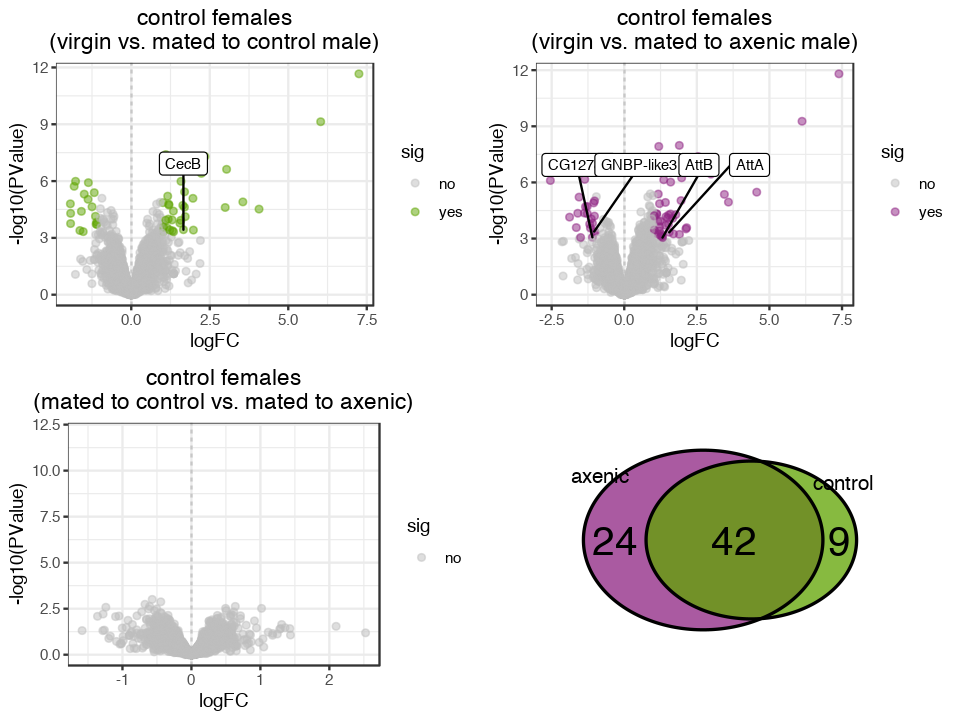

In [50]:
options(repr.plot.width = 8, repr.plot.height =6)
# pdf("Results/Figures/mated_control_female_contrasts_panel.pdf", width = 8, height = 6)
plot_grid(CC.v.C_contrasts_volcano.gg, CA.v.C_contrasts_volcano.gg, CC.v.CA_contrasts_volcano.gg, myVennn, ncol = 2, nrow = 2, scale = c(1, 1, 1, 0.6))
# dev.off()

Make a factor object with elements of the above venn diagram:

In [51]:
matedControlFemale.factors = as.data.frame(unlist(CCxC.v.CAxC.v.CCxCA_elements))
matedControlFemale.factors$cat = rownames(matedControlFemale.factors)
matedControlFemale.factors$cat = gsub("[[:digit:]]", "", matedControlFemale.factors$cat)
colnames(matedControlFemale.factors) = c("FBgn_ID", "category")
rownames(matedControlFemale.factors) = matedControlFemale.factors$FBgn_ID
matedControlFemale.factors = subset(matedControlFemale.factors, select = "category")
matedControlFemale.factors$category = gsub(",", "_", matedControlFemale.factors$category)
matedControlFemale.factor_list = unique(matedControlFemale.factors[,1])

Output individual gene plots for each category of the venn diagram:

In [52]:
# for (feature_cat in matedControlFemale.factor_list) {
#     tmp.Plots = suppressMessages(lapply(rownames(matedControlFemale.factors)[matedControlFemale.factors$category == feature_cat], geneBarPlot_mon_byFemale, tpmTable = tpm.table.rc, female = "control", show_reps = T))
#     ggsave(paste("Results/Figures/single_gene_plots/matedControlFemale.", feature_cat, ".pdf", sep = ""), marrangeGrob(grobs = tmp.Plots, nrow = 2, ncol =2))
# }


Output a gene snapshot table:

In [53]:
matedControlFemale_gene_snapshots_list = list()
for (feature_cat in matedControlFemale.factor_list) {
    tmpInfo = filter(snapshots, FBgn_ID %in% rownames(matedControlFemale.factors)[matedControlFemale.factors$category == feature_cat])
    tmpInfo = select(tmpInfo, -datestamp)
    category = feature_cat
    tmpInfo$category = category
    matedControlFemale_gene_snapshots_list[[feature_cat]] = tmpInfo
}
matedControlFemale_gene_snapshots = rbindlist(matedControlFemale_gene_snapshots_list)
# write.table(matedControlFemale_gene_snapshots, "Results/Tables/matedControlFemale_sigGenes_snapshots.txt", quote = F, sep = "\t", row.names = F)
rm(matedControlFemale_gene_snapshots_list)

### Contrast between virgin and mated axenic females:

Set up the contrasts:

In [54]:
AA.v.A_contrasts <- makeContrasts(AA-A, levels=design_2)
AC.v.A_contrasts <- makeContrasts(AC-A, levels=design_2)

Now compare the mated axenic females to virgin axenic females. First, females mated to axenic males

In [55]:
# run the LRT and extract the DE table
lrt.AA.v.A.table <- edge.DE(dgeList_fit, AA.v.A_contrasts, LRT = F)

AA.v.A_sigGenes = subset(lrt.AA.v.A.table, sig == "yes" & gene %!in% mm_genes)$gene
AA.v.A_sigGenes_up = subset(lrt.AA.v.A.table, sig == "yes" & gene %!in% mm_genes & logFC > 1)$gene
AA.v.A_sigGenes_down = subset(lrt.AA.v.A.table, sig == "yes" & gene %!in% mm_genes & logFC < -1)$gene

options(repr.plot.width = 4, repr.plot.height = 3.5)
AA.v.A_contrasts_volcano.gg = edge.DE.gg(lrt.AA.v.A.table) +
                                scale_colour_manual(values = c("grey","#ffad35")) +
                                geom_label_repel(data = filter(lrt.AA.v.A.table, sig == "yes" & gene %in% immunity_genes),aes(label=gene_symbol), 
                                force = 10,
                                fontface = "bold", 
                                size = 3,
                                colour = "#7a5100",
#                                 ylim = c(6, NA),
                                               ) +
                                labs(title = "axenic females\n(virgin vs. mated to axenic male)", size = 2) +
#                                 theme_black_full() +
                                theme(axis.text.x = element_text(angle = 0), plot.title = element_text(hjust = 0.5))
                                

... and females mated to control males

In [56]:
# run the LRT and extract the DE table
lrt.AC.v.A.table <- edge.DE(dgeList_fit, AC.v.A_contrasts, LRT = F)

AC.v.A_sigGenes = subset(lrt.AC.v.A.table, sig == "yes" & gene %!in% mm_genes)$gene
AC.v.A_sigGenes_up = subset(lrt.AC.v.A.table, sig == "yes" & gene %!in% mm_genes & logFC > 1)$gene
AC.v.A_sigGenes_down = subset(lrt.AC.v.A.table, sig == "yes" & gene %!in% mm_genes & logFC < -1)$gene

options(repr.plot.width = 4, repr.plot.height = 3.5)
AC.v.A_contrasts_volcano.gg = edge.DE.gg(lrt.AC.v.A.table) +
                                scale_colour_manual(values = c("grey","#255488")) +
                                geom_label_repel(data = filter(lrt.AC.v.A.table, sig == "yes" & gene %in% immunity_genes),aes(label=gene_symbol), 
                                force = 30,
                                fontface = "bold", 
                                size = 3,
#                                 ylim = c(6, NA),
                                colour = "#7a5100") +
                                labs(title = "axenic females\n(virgin vs. mated to control male)", size = 2) +
#                                 theme_black_full() +
                                theme(axis.text.x = element_text(angle = 0), plot.title = element_text(hjust = 0.5))

Let's directly compare DE between the AC and AA samples. First set up the contrast:

In [57]:
AC.v.AA_contrasts <- makeContrasts(AC-AA, levels=design_2)

Now perform the test:

In [58]:
# run the LRT and extract the DE table
lrt.AC.v.AA.table <- edge.DE(dgeList_fit, AC.v.AA_contrasts, LRT = F)

AC.v.AA_sigGenes = subset(lrt.AC.v.AA.table, sig == "yes" & gene %!in% mm_genes)$gene
AC.v.AA_sigGenes_up = subset(lrt.AC.v.AA.table, sig == "yes" & gene %!in% mm_genes & logFC > 1)$gene
AC.v.AA_sigGenes_down = subset(lrt.AC.v.AA.table, sig == "yes" & gene %!in% mm_genes & logFC < -1)$gene

options(repr.plot.width = 4, repr.plot.height = 3)
AC.v.AA_contrasts_volcano.gg = edge.DE.gg(lrt.AC.v.AA.table) +
                                scale_colour_manual(values = c("grey","#982b1e")) +
                                geom_label_repel(data = filter(lrt.AC.v.AA.table, sig == "yes" & gene %in% immunity_genes),aes(label=gene_symbol), 
                                force = 30,
                                fontface = "bold", 
                                size = 3,
#                                 ylim = c(6, NA),
                                colour = "#006294") +
                                labs(title = "axenic females\n(mated to control vs. mated to axenic)", size = 2) +
#                                 theme_black_full() +
                                theme(axis.text.x = element_text(angle = 0), plot.title = element_text(hjust = 0.5))

We can now directly look at the overlap between the three contrasts:

In [59]:
AAxA.v.ACxA.v.ACxAA_candidates <- list(axenic = AA.v.A_sigGenes, 
                        control = AC.v.A_sigGenes,
                                between = AC.v.AA_sigGenes)

AAxA.v.ACxA.v.ACxAA_Vdiag<-venn.diagram(AAxA.v.ACxA.v.ACxAA_candidates, NULL, fill=c("#ffad35","#006294","#982b1e"), alpha=c(0.75,0.75, 0.75), cex = 2, cat.fontface= 6, cat.cex = 1, resolution = 100, )

AAxA.v.ACxA.v.ACxAA_combs <- unlist(lapply(1:length(AAxA.v.ACxA.v.ACxAA_candidates), function(j) combn(names(AAxA.v.ACxA.v.ACxAA_candidates), j, simplify = FALSE)), recursive = FALSE)
names(AAxA.v.ACxA.v.ACxAA_combs) <- sapply(AAxA.v.ACxA.v.ACxAA_combs, function(i) paste0(i, collapse = ","))
AAxA.v.ACxA.v.ACxAA_elements <- lapply(AAxA.v.ACxA.v.ACxAA_combs, function(i) Setdiff(AAxA.v.ACxA.v.ACxAA_candidates[i], AAxA.v.ACxA.v.ACxAA_candidates[setdiff(names(AAxA.v.ACxA.v.ACxAA_candidates), i)]))

options(repr.plot.width = 3, repr.plot.height =2)
# grid.arrange(gTree(children=AAxA.v.ACxA.v.ACxAA_Vdiag))
    myVennn = arrangeGrob(gTree(children=AAxA.v.ACxA.v.ACxAA_Vdiag))
summary(AAxA.v.ACxA.v.ACxAA_elements)
rm(AAxA.v.ACxA.v.ACxAA_candidates, AAxA.v.ACxA.v.ACxAA_Vdiag, AAxA.v.ACxA.v.ACxAA_combs)

                       Length Class  Mode     
axenic                 67     -none- character
control                31     -none- character
between                94     -none- character
axenic,control         44     -none- character
axenic,between         19     -none- character
control,between        18     -none- character
axenic,control,between  4     -none- character

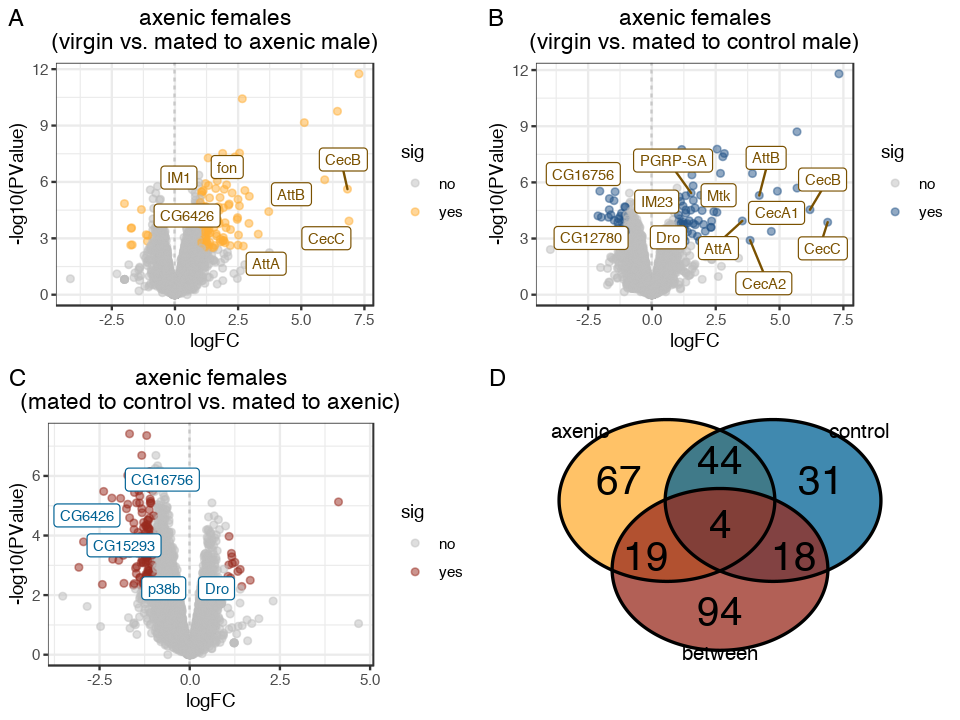

In [60]:
options(repr.plot.width = 8, repr.plot.height =6)
# pdf("Results/Figures/mated_axenic_female_contrasts_panel.pdf", width = 8, height = 6)
plot_grid(AA.v.A_contrasts_volcano.gg, AC.v.A_contrasts_volcano.gg, AC.v.AA_contrasts_volcano.gg, myVennn, ncol = 2, nrow = 2, scale = c(1, 1, 1, 0.7), labels = c("A", "B", "C", "D"))
# dev.off()

Make a factor object with elements of the above venn diagram:

In [61]:
matedAxenicFemale.factors = as.data.frame(unlist(AAxA.v.ACxA.v.ACxAA_elements))
matedAxenicFemale.factors$cat = rownames(matedAxenicFemale.factors)
matedAxenicFemale.factors$cat = gsub("[[:digit:]]", "", matedAxenicFemale.factors$cat)
colnames(matedAxenicFemale.factors) = c("FBgn_ID", "category")
rownames(matedAxenicFemale.factors) = matedAxenicFemale.factors$FBgn_ID
matedAxenicFemale.factors = subset(matedAxenicFemale.factors, select = "category")
matedAxenicFemale.factors$category = gsub(",", "_", matedAxenicFemale.factors$category)
matedAxenicFemale.factor_list = unique(matedAxenicFemale.factors[,1])

Output individual gene plots for each category of the venn diagram:

In [62]:
for (feature_cat in matedAxenicFemale.factor_list) {
    tmp.Plots = suppressMessages(lapply(rownames(matedAxenicFemale.factors)[matedAxenicFemale.factors$category == feature_cat], geneBarPlot_mon_byFemale, tpmTable = tpm.table.rc, female = "axenic", show_reps = T))
#     ggsave(paste("Results/Figures/single_gene_plots/matedAxenicFemale.", feature_cat, ".pdf", sep = ""), marrangeGrob(grobs = tmp.Plots, nrow = 2, ncol =2))
}


Output a gene snapshot table:

In [63]:
matedAxenicFemale_gene_snapshots_list = list()
for (feature_cat in matedAxenicFemale.factor_list) {
    tmpInfo = filter(snapshots, FBgn_ID %in% rownames(matedAxenicFemale.factors)[matedAxenicFemale.factors$category == feature_cat])
    tmpInfo = select(tmpInfo, -datestamp)
    category = feature_cat
    tmpInfo$category = category
    matedAxenicFemale_gene_snapshots_list[[feature_cat]] = tmpInfo
}
matedAxenicFemale_gene_snapshots = rbindlist(matedAxenicFemale_gene_snapshots_list)
# write.table(matedAxenicFemale_gene_snapshots, "Results/Tables/matedAxenicFemale_sigGenes_snapshots.txt", quote = F, sep = "\t", row.names = F)
rm(matedAxenicFemale_gene_snapshots_list)

Check the overlap between the mating response genes:

                    Length Class  Mode     
CaCo                19     -none- character
CcCo                 4     -none- character
AaAo                82     -none- character
AcAo                41     -none- character
CaCo,CcCo           12     -none- character
CaCo,AaAo            0     -none- character
CaCo,AcAo            1     -none- character
CcCo,AaAo            2     -none- character
CcCo,AcAo            1     -none- character
AaAo,AcAo           20     -none- character
CaCo,CcCo,AaAo       2     -none- character
CaCo,CcCo,AcAo       6     -none- character
CaCo,AaAo,AcAo       4     -none- character
CcCo,AaAo,AcAo       2     -none- character
CaCo,CcCo,AaAo,AcAo 22     -none- character

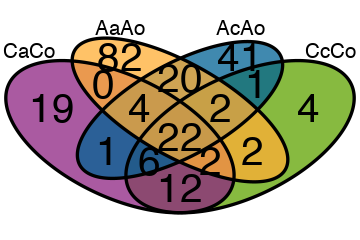

In [64]:
tempo_candidates <- list(CaCo = CA.v.C_sigGenes, 
                        CcCo = CC.v.C_sigGenes,
                        AaAo = AA.v.A_sigGenes, 
                        AcAo = AC.v.A_sigGenes)

tempo_Vdiag<-venn.diagram(tempo_candidates, NULL, fill=c("#8e2381","#5fa300","#ffad35","#006294"), alpha=c(0.75, 0.75, 0.75, 0.75), cex = 2, cat.fontface= 6, cat.cex = 1, resolution = 100, )

tempo_combs <- unlist(lapply(1:length(tempo_candidates), function(j) combn(names(tempo_candidates), j, simplify = FALSE)), recursive = FALSE)
names(tempo_combs) <- sapply(tempo_combs, function(i) paste0(i, collapse = ","))
tempo_elements <- lapply(tempo_combs, function(i) Setdiff(tempo_candidates[i], tempo_candidates[setdiff(names(tempo_candidates), i)]))

options(repr.plot.width = 3, repr.plot.height =2)
grid.arrange(gTree(children=tempo_Vdiag))
    myVennn = arrangeGrob(gTree(children=tempo_Vdiag))
summary(tempo_elements)
# rm(tempo_candidates, tempo_Vdiag, tempo_combs)

### Virgin female contrasts (axenic vs. control):

First we'll set up the contrast:

In [65]:
# pairwise contrasts
virgin_contrasts <- makeContrasts(C-A, levels=design_2)

Now look at the difference between the axenic and control virgin samples:

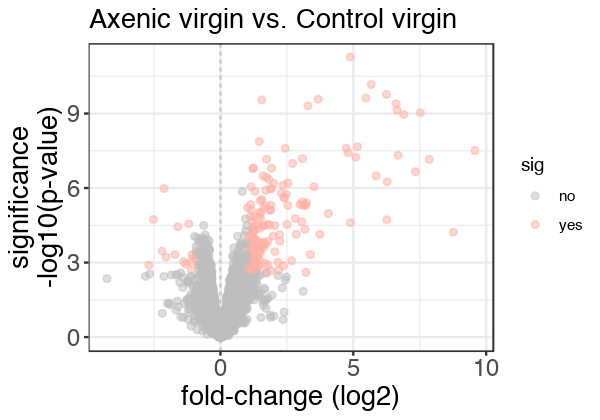

In [66]:
# run the LRT and extract the DE table
lrt.virgins.table <- edge.DE(dgeList_fit, virgin_contrasts, LRT = F)

virgins_sigGenes = subset(lrt.virgins.table, sig == "yes"  )$gene
virgins_sigGenes_up = subset(lrt.virgins.table, sig == "yes"   & logFC > 1)$gene
virgins_sigGenes_down = subset(lrt.virgins.table, sig == "yes"  & logFC < -1)$gene

options(repr.plot.width = 5, repr.plot.height = 3.5)
# pdf("Results/Figures/virgin_female_contrast_volcanoPlot.pdf", width = 5, height = 3.5)
(virgin_contrasts_volcano.gg = edge.DE.gg(lrt.virgins.table) +
                                scale_colour_manual(values = c("grey", "#feb0a4")) +
#                                 geom_label_repel(data = filter(lrt.virgins.table, sig == "yes" & gene %in% immunity_genes),aes(label=gene_symbol), 
#                                 force = 30,
#                                 colour = "#4d5806",
#                                 fontface = "bold", 
# #                                 size = 3,
# #                                 xlim = c(NA, 5),
# #                                 ylim = c(6.5, NA),
#                                                 ) +
                                labs(x = "fold-change (log2)", y = "significance\n-log10(p-value)") +
                                labs(title = "Axenic virgin vs. Control virgin", size = 2) +
#                                 theme_monokai_full() + 
                                theme(axis.text = element_text(angle = 0, size = 14),
                                     axis.title = element_text(size = 16),
                                     plot.title = element_text(size = 16)))
ggsave("Results/manuscript_figures/virgin_contrasts_volcanoPlot.pdf", width = 5, height = 3.5)

Look at a heatmap of these results, partciularly the immunity genes:

These plots show that many DE genes are immune-related. We can list those here:

In [67]:
subset(immunity_genes.df, FlyBaseID %in% virgins_sigGenes)

,FlyBaseID,Symbol,Name,Synonyms,Chr,Cyto,Functional Class,Notes
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
7,FBgn0012042,AttA,Attacin-A,.,2R,51C1,effector,antimicrobial peptide
8,FBgn0041581,AttB,Attacin-B,.,2R,51C1,effector,antimicrobial peptide
9,FBgn0041579,AttC,Attacin-C,.,2R,50A3,effector,antimicrobial peptide
19,FBgn0000276,CecA1,Cecropin A1,.,3R,99E2,effector,antimicrobial peptide
20,FBgn0000277,CecA2,Cecropin A2,.,3R,99E2,effector,antimicrobial peptide
21,FBgn0000278,CecB,Cecropin B,.,3R,99E2,effector,antimicrobial peptide
22,FBgn0000279,CecC,Cecropin C,.,3R,99E2,effector,antimicrobial peptide
54,FBgn0030774,CG9675,.,spheroide,X,15A1--2,signaling,protease
69,FBgn0004240,Dpt,Diptericin,.,2R,55F8,effector,antimicrobial peptide


### Comparing axenic and control mated females:

In [68]:
mated.contrast <- makeContrasts(((CA+CC)/2) - ((AA+AC)/2), levels = design_2)

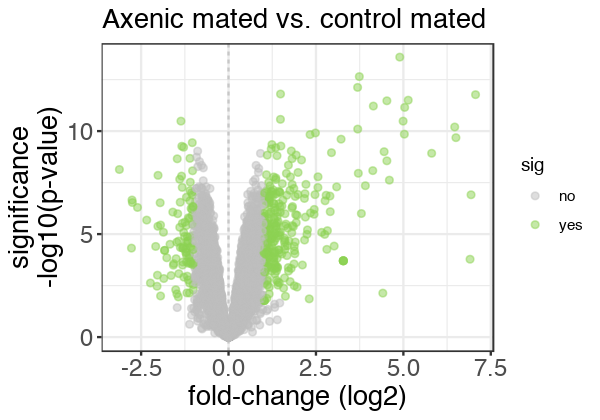

In [69]:
options(repr.plot.width = 5, repr.plot.height = 3.5)
lrt.mated.table <- edge.DE(dgeList_fit,mated.contrast, LRT = F)
# lrt.mated.table <- filter(lrt.mated.table, gene %!in% virgins_sigGenes)

mated_sigGenes = subset(lrt.mated.table, sig == "yes" )$gene
mated_sigGenes_up = subset(lrt.mated.table, sig == "yes"  & logFC > 1)$gene
mated_sigGenes_down = subset(lrt.mated.table, sig == "yes" & logFC < -1)$gene

edge.DE.gg(lrt.mated.table) +
                                scale_colour_manual(values = c("grey", "#8cd253")) +
#                                 geom_text_repel(data = filter(lrt.mated.table, sig == "yes" & gene %in% immunity_genes),aes(label=gene_symbol), 
#                                 force = 30,
#                                 colour = "green",
#                                 fontface = "bold", 
#                                 size = 3,
#                                 ylim = c(5, NA)) +
                                labs(x = "fold-change (log2)", y = "significance\n-log10(p-value)") +
                                labs(title = "Axenic mated vs. control mated") +
                                theme(axis.text = element_text(angle = 0, size = 14),
                                     axis.title = element_text(size = 16),
                                     plot.title = element_text(size = 16))
ggsave("Results/manuscript_figures/mated_contrasts_volcanoPlot.pdf", width = 5, height = 3.5)

Check the overlap between the significant genes in the virgin contrasts and in the mated contrasts:

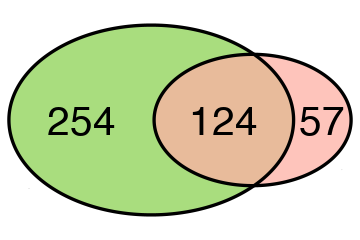

In [70]:
micRes_candidates <- list(virgin = virgins_sigGenes, 
                        mated = mated_sigGenes)

micRes_Vdiag<-venn.diagram(micRes_candidates, NULL, fill=c("#feb0a4","#8cd253"), alpha=c(0.75, 0.75), cex = 2, cat.fontface= 1, cat.cex = 0, resolution = 100, )

micRes_combs <- unlist(lapply(1:length(micRes_candidates), function(j) combn(names(micRes_candidates), j, simplify = FALSE)), recursive = FALSE)
names(micRes_combs) <- sapply(micRes_combs, function(i) paste0(i, collapse = ","))
micRes_elements <- lapply(micRes_combs, function(i) Setdiff(micRes_candidates[i], micRes_candidates[setdiff(names(micRes_candidates), i)]))

options(repr.plot.width = 3, repr.plot.height =2)
# pdf("Results/manuscript_figures/mated_virgins_sigVenn.pdf", width = 3, height = 2)
grid.arrange(gTree(children=micRes_Vdiag))
    myVennn = arrangeGrob(gTree(children=micRes_Vdiag))
# dev.off()
# summary(micRes_elements)
# rm(micRes_candidates, micRes_Vdiag, micRes_combs)

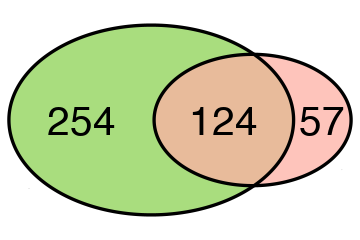

In [71]:
micRes_candidates <- list(virgin = virgins_sigGenes, 
                        mated = mated_sigGenes)

micRes_Vdiag<-venn.diagram(micRes_candidates, NULL, fill=c("#feb0a4","#8cd253"), alpha=c(0.75, 0.75), cex = 2, cat.fontface= 1, cat.cex = 0, resolution = 100, )

micRes_combs <- unlist(lapply(1:length(micRes_candidates), function(j) combn(names(micRes_candidates), j, simplify = FALSE)), recursive = FALSE)
names(micRes_combs) <- sapply(micRes_combs, function(i) paste0(i, collapse = ","))
micRes_elements <- lapply(micRes_combs, function(i) Setdiff(micRes_candidates[i], micRes_candidates[setdiff(names(micRes_candidates), i)]))

options(repr.plot.width = 3, repr.plot.height =2)
# pdf("Results/manuscript_figures/mated_virgins_sigVenn.pdf", width = 3, height = 2)
grid.arrange(gTree(children=micRes_Vdiag))
    myVennn = arrangeGrob(gTree(children=micRes_Vdiag))
# dev.off()
# summary(micRes_elements)
# rm(micRes_candidates, micRes_Vdiag, micRes_combs)

Output Entrez ID lists for the significant gene categories:

In [72]:
as_tibble(lrt.virgins.table) %>% 
    filter(sig == "yes" & gene %!in% mm_genes & gene %!in% mm_genes) %>% 
    rename(FBgn_ID = gene)  %>% 
    left_join(Entrez_mappings, by = "FBgn_ID")  %>% 
    pull(ent_id) -> virgins_entrezId

as_tibble(lrt.virgins.table) %>% 
    filter(direction == "Up" & gene %!in% mm_genes) %>% 
    rename(FBgn_ID = gene)  %>% 
    left_join(Entrez_mappings, by = "FBgn_ID")  %>% 
    pull(ent_id) -> virginsUp_entrezId

as_tibble(lrt.virgins.table) %>% 
    filter(direction == "Down" & gene %!in% mm_genes) %>% 
    rename(FBgn_ID = gene)  %>% 
    left_join(Entrez_mappings, by = "FBgn_ID")  %>% 
    pull(ent_id) -> virginsDown_entrezId

as_tibble(lrt.mated.table) %>% 
    filter(sig == "yes" & gene %!in% mm_genes) %>% 
    rename(FBgn_ID = gene)  %>% 
    left_join(Entrez_mappings, by = "FBgn_ID")  %>% 
    pull(ent_id) -> mated_entrezId

as_tibble(lrt.mated.table) %>% 
    filter(direction == "Up" & gene %!in% mm_genes) %>% 
    rename(FBgn_ID = gene)  %>% 
    left_join(Entrez_mappings, by = "FBgn_ID")  %>% 
    pull(ent_id) -> matedUp_entrezId

as_tibble(lrt.mated.table) %>% 
    filter(direction == "Down" & gene %!in% mm_genes) %>% 
    rename(FBgn_ID = gene)  %>% 
    left_join(Entrez_mappings, by = "FBgn_ID")  %>% 
    pull(ent_id) -> matedDown_entrezId

as_tibble(lrt.virgins.table) %>% 
    filter(gene %in% micRes_elements$`virgin,mated` & gene %!in% mm_genes) %>% 
    rename(FBgn_ID = gene)  %>% 
    left_join(Entrez_mappings, by = "FBgn_ID")  %>% 
    pull(ent_id) -> core_entrezId

as_tibble(lrt.virgins.table) %>% 
    filter(gene %in% micRes_elements$virgin & gene %!in% mm_genes) %>% 
    rename(FBgn_ID = gene)  %>% 
    left_join(Entrez_mappings, by = "FBgn_ID")  %>% 
    pull(ent_id) -> virSig_entrezId

as_tibble(lrt.mated.table) %>% 
    filter(gene %in% micRes_elements$mated & gene %!in% mm_genes) %>% 
    rename(FBgn_ID = gene)  %>% 
    left_join(Entrez_mappings, by = "FBgn_ID")  %>% 
    pull(ent_id) -> matSig_entrezId

as_tibble(lrt.mated.table) %>% 
    filter(gene %in% micRes_elements$mated & gene %!in% mm_genes & gene %in% filter(lrt.mated.table, direction == "Up")$gene) %>% 
    rename(FBgn_ID = gene)  %>% 
    left_join(Entrez_mappings, by = "FBgn_ID")  %>% 
    pull(ent_id) -> matSigUp_entrezId

as_tibble(lrt.mated.table) %>% 
    filter(gene %in% micRes_elements$mated & gene %!in% mm_genes & gene %in% filter(lrt.mated.table, direction == "Down")$gene) %>% 
    rename(FBgn_ID = gene)  %>% 
    left_join(Entrez_mappings, by = "FBgn_ID")  %>% 
    pull(ent_id) -> matSigDown_entrezId

as_tibble(lrt.virgins.table) %>% 
    rename(FBgn_ID = gene)  %>% 
    left_join(Entrez_mappings, by = "FBgn_ID")  %>% 
    pull(ent_id) -> all_entrezId

Now perform GO enrichment analysis and create a custom dotplot

In [73]:
ego <- enrichGO(gene          = core_entrezId,
                universe      = all_entrezId,
                OrgDb         = org.Dm.eg.db,
                ont           = "MF",
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.05,
                qvalueCutoff  = 0.05,
                minGSSize = 5)

# myEGO <- as.data.frame(gofilter(ego, level = 3))
myEGO <- as.data.frame(ego)
myEGO$DEset = as.numeric(gsub(".*\\/", "", myEGO$GeneRatio))
myEGO$`gene ratio` = myEGO$Count/myEGO$DEset

options(repr.plot.width = 8, repr.plot.height = 5)
core_GO_MF_gg <- ggplot(myEGO, aes(reorder(Description, -pvalue), -log10(pvalue), colour = `gene ratio`, size = Count)) +    geom_point() +
 coord_flip() +
scale_colour_viridis() +
theme(axis.title.y = element_blank()) +
labs(title = "Core genes\n(Molecular Function)" )+
ggsave("Results/manuscript_figures/GO_core_MF.pdf", height = 6, width = 8)

In [74]:
ego <- enrichGO(gene          = core_entrezId,
                universe      = all_entrezId,
                OrgDb         = org.Dm.eg.db,
                ont           = "BP",
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.05,
                qvalueCutoff  = 0.05,
                minGSSize = 2,
                readable      = TRUE)

myEGO <- as.data.frame(ego)
# myEGO <- as.data.frame(gofilter(ego, level = 4))
myEGO$DEset = as.numeric(gsub(".*\\/", "", myEGO$GeneRatio))
myEGO$`gene ratio` = myEGO$Count/myEGO$DEset

options(repr.plot.width = 8, repr.plot.height = 6)
core_GO_BP_gg <- ggplot(myEGO, aes(reorder(Description, -pvalue), -log10(pvalue), colour = `gene ratio`, size = Count)) +    geom_point() +
 coord_flip() +
scale_colour_viridis() +
theme(axis.title.y = element_blank()) +
labs(title = "Core genes\n(Biological Process)" ) +
ggsave("Results/manuscript_figures/GO_core_BP.pdf", height = 6, width = 8)

In [75]:
ego <- enrichGO(gene          = virSig_entrezId,
                universe      = all_entrezId,
                OrgDb         = org.Dm.eg.db,
                ont           = "MF",
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.05,
                qvalueCutoff  = 0.1,
                minGSSize = 2,
                readable      = TRUE)

myEGO <- as.data.frame(ego)
myEGO$DEset = as.numeric(gsub(".*\\/", "", myEGO$GeneRatio))
myEGO$`gene ratio` = myEGO$Count/myEGO$DEset

options(repr.plot.width = 8, repr.plot.height = 4.75)
virgin_GO_MF_gg <- ggplot(myEGO, aes(reorder(Description, -pvalue), -log10(pvalue), colour = `gene ratio`, size = Count)) +    geom_point() +
 coord_flip() +
scale_colour_viridis() +
theme(axis.title.y = element_blank()) +
labs(title = "virgin response genes\n(Biological Process)")

In [76]:
ego <- enrichGO(gene          = matSigDown_entrezId,
                universe      = all_entrezId,
                OrgDb         = org.Dm.eg.db,
                ont           = "BP",
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.05,
                qvalueCutoff  = 0.05,
                minGSSize = 5)

myEGO <- as.data.frame(gofilter(ego, level = 6))
# myEGO <- as.data.frame(ego)
myEGO$DEset = as.numeric(gsub(".*\\/", "", myEGO$GeneRatio))
myEGO$`gene ratio` = myEGO$Count/myEGO$DEset

options(repr.plot.width = 8, repr.plot.height = 7)
# myEGO= filter(myEGO, Description != "hormone activity" & Description != "amine catabolic process" &Description != "extracellular space" & Description != "detection of stimulus" & Description != "detection of external stimulus" & Description != "sensory perception of chemical stimulus" & Description != "entrainment of circadian clock" & Description != "detection of abiotic stimulus" & Description != "phototransduction, visible light")
mated_GO_MF_up_gg <- ggplot(myEGO, aes(reorder(Description, -pvalue), -log10(pvalue), colour = `gene ratio`, size = Count)) +    geom_point() +
 coord_flip() +
# facet_grid(ONTOLOGY~., space = "free", scale = "free") +
scale_colour_viridis() +
theme(axis.title.y = element_blank()) +
labs(title = "Axenic mating\n(Biological Process)" )
# +
# ggsave("Results/manuscript_figures/GO_core_MF.pdf", height = 6, width = 8)

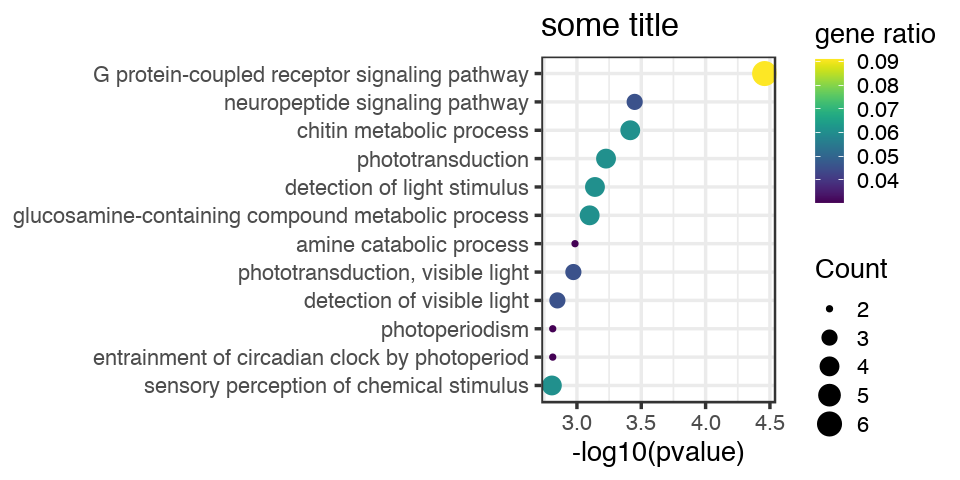

In [77]:
options(repr.plot.width = 8, repr.plot.height = 4)

ggplot(myEGO, aes(reorder(Description, -pvalue), -log10(pvalue), colour = `gene ratio`, size = Count)) + 
    geom_point() +
    coord_flip() +
    # facet_grid(ONTOLOGY~., space = "free", scale = "free") + ## if you have a column with different ontology terms
    scale_colour_viridis() +
    theme(axis.title.y = element_blank()) +
    labs(title = "some title" )

Combine those three plots:

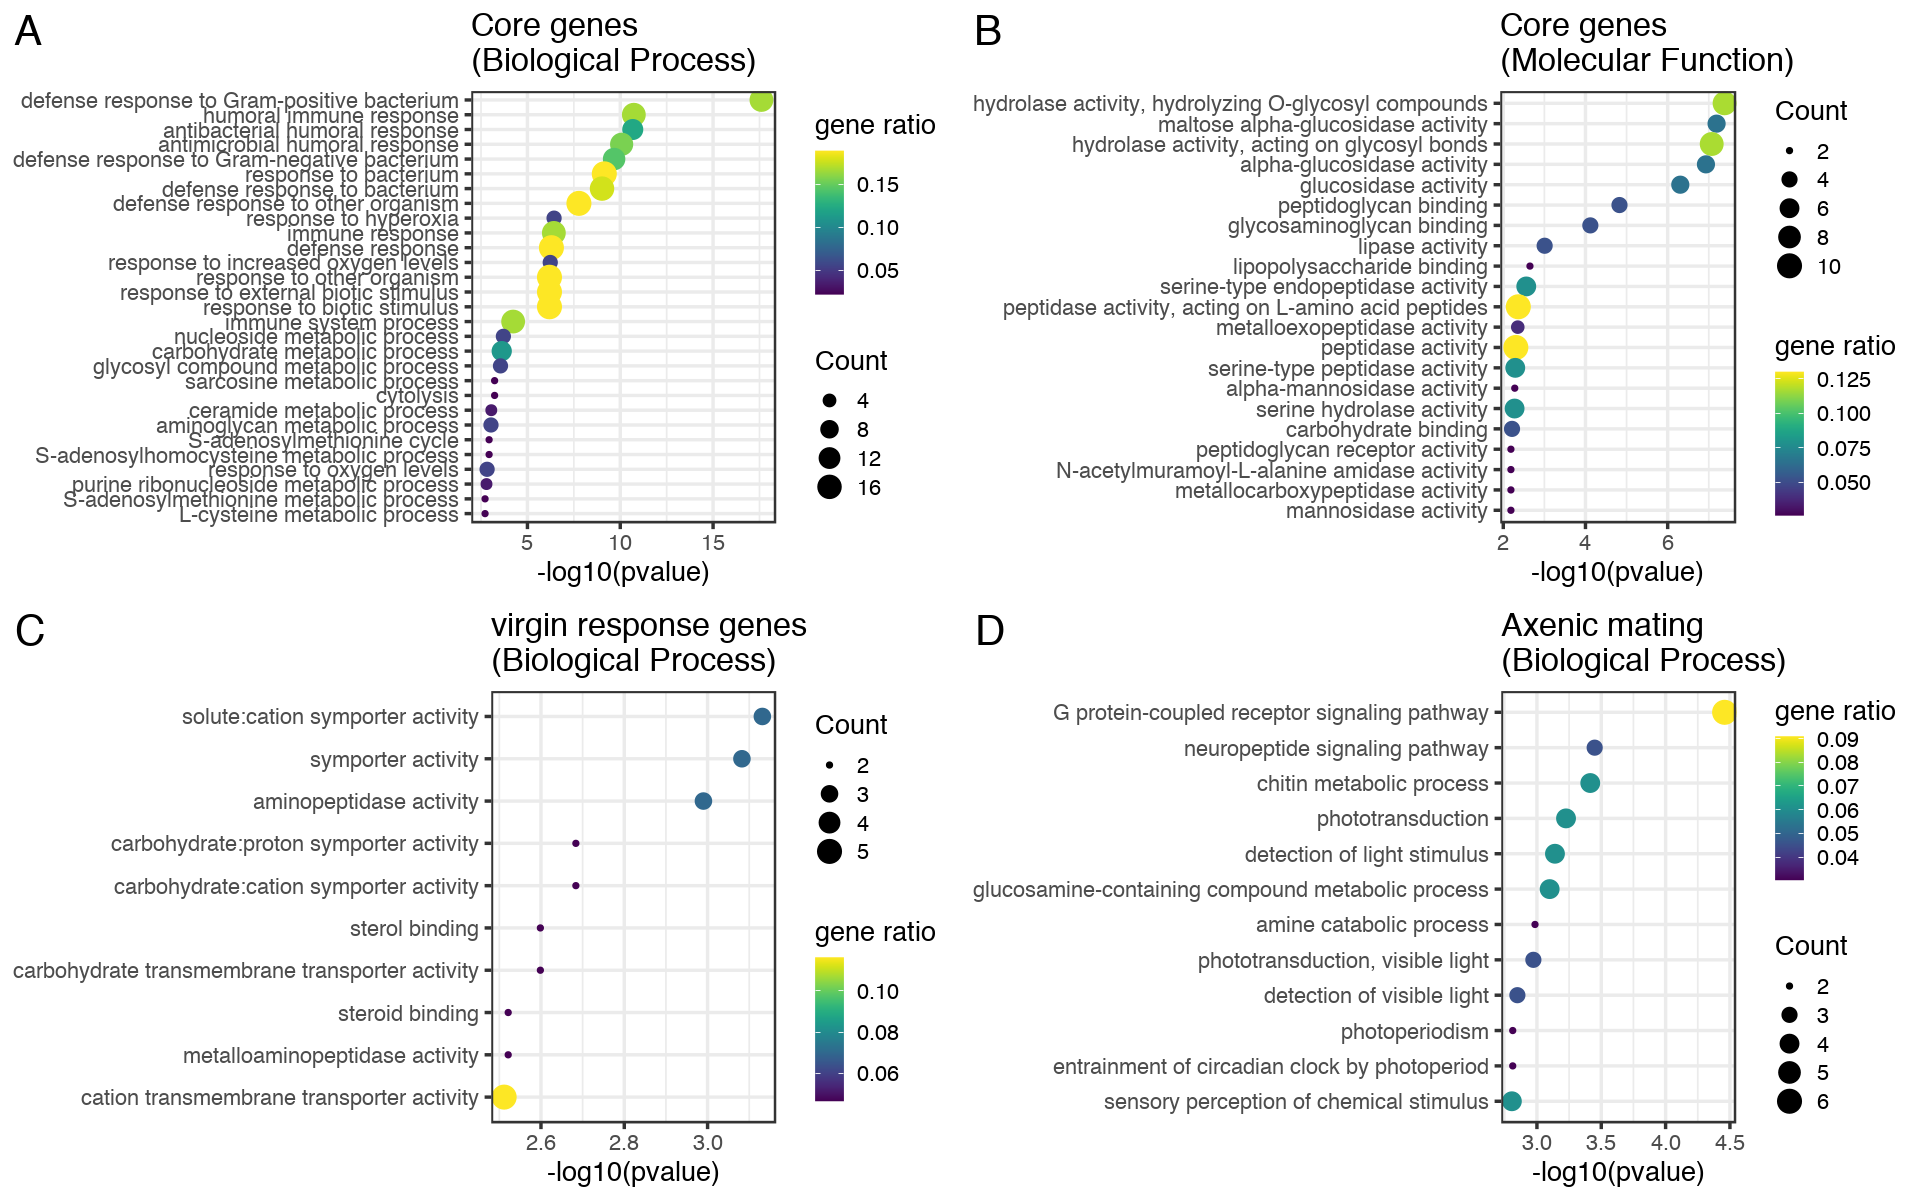

In [78]:
options(repr.plot.width = 16, repr.plot.height = 10)
plot_grid(core_GO_BP_gg, core_GO_MF_gg, virgin_GO_MF_gg, mated_GO_MF_up_gg, ncol = 2, nrow = 2, scale = c(1, 1, 1, 1), labels = c("A", "B", "C", "D"), label_size = 25) +
    ggsave("Results/manuscript_figures/Figure_S4.pdf", height = 10, width = 16)

And also KEGG pathways:

In [79]:
virgins_sigGenes_altIDs = subset(annotation, primary_FBgn %in% virgins_sigGenes & !is.na(annotation_ID))
virgins_sigGenes_altIDs = paste(virgins_sigGenes_altIDs$organism_abbreviation, virgins_sigGenes_altIDs$annotation_ID, sep = "_")
virgins_kegg <- enrichKEGG(gene = virgins_sigGenes_altIDs, organism = 'dme')
subset(virgins_kegg@result, qvalue < 0.05)
# write.table(virgins_kegg@result, "Results/Tables/virgins_sigGenes_KEGG_enirchment.txt", quote = F, sep = "\t", row.names = F)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
dme04624,dme04624,Toll and Imd signaling pathway,10/48,81/3245,1.621040e-07,3.891501e-06,2.774924e-06,Dmel_CG10794/Dmel_CG12763/Dmel_CG14704/Dmel_CG9681/Dmel_CG1373/Dmel_CG1365/Dmel_CG1367/Dmel_CG1878/Dmel_CG14745/Dmel_CG9675,10
dme00500,dme00500,Starch and sucrose metabolism,7/48,32/3245,2.510646e-07,3.891501e-06,2.774924e-06,Dmel_CG8221/Dmel_CG8694/Dmel_CG8690/Dmel_CG8693/Dmel_CG8695/Dmel_CG8696/Dmel_CG11669,7
dme00052,dme00052,Galactose metabolism,6/48,36/3245,1.058794e-05,1.094087e-04,7.801642e-05,Dmel_CG8694/Dmel_CG8690/Dmel_CG8693/Dmel_CG8695/Dmel_CG8696/Dmel_CG11669,6
dme04142,dme04142,Lysosome,9/48,119/3245,4.447517e-05,3.446826e-04,2.457838e-04,Dmel_CG11315/Dmel_CG9463/Dmel_CG9468/Dmel_CG9494/Dmel_CG31410/Dmel_CG12602/Dmel_CG11314/Dmel_CG8823/Dmel_CG31148,9
dme00511,dme00511,Other glycan degradation,3/48,22/3245,3.840521e-03,2.381123e-02,1.697914e-02,Dmel_CG9463/Dmel_CG9468/Dmel_CG31148,3
dme00480,dme00480,Glutathione metabolism,5/48,79/3245,5.683144e-03,2.936291e-02,2.093790e-02,Dmel_CG31233/Dmel_CG4421/Dmel_CG4181/Dmel_CG17524/Dmel_CG8721,5
dme00600,dme00600,Sphingolipid metabolism,3/48,28/3245,7.677634e-03,3.400095e-02,2.424516e-02,Dmel_CG11425/Dmel_CG3576/Dmel_CG31148,3
dme00983,dme00983,Drug metabolism - other enzymes,5/48,96/3245,1.277818e-02,4.951546e-02,3.530814e-02,Dmel_CG4421/Dmel_CG4181/Dmel_CG17524/Dmel_CG8353/Dmel_CG6633,5
dme00982,dme00982,Drug metabolism - cytochrome P450,4/48,68/3245,1.717158e-02,5.590390e-02,3.986356e-02,Dmel_CG4421/Dmel_CG4181/Dmel_CG17524/Dmel_CG6633,4


In [80]:
mated_sigGenes_altIDs = subset(annotation, primary_FBgn %in% mated_sigGenes & !is.na(annotation_ID))
mated_sigGenes_altIDs = paste(mated_sigGenes_altIDs$organism_abbreviation, mated_sigGenes_altIDs$annotation_ID, sep = "_")
mated_kegg <- enrichKEGG(gene = mated_sigGenes_altIDs, organism = 'dme')
subset(mated_kegg@result, qvalue < 0.05)
# write.table(mated_kegg@result, "Results/Tables/mated_sigGenes_KEGG_enirchment.txt", quote = F, sep = "\t", row.names = F)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
dme04624,dme04624,Toll and Imd signaling pathway,13/89,81/3245,1.681712e-07,1.093113e-05,1.044431e-05,Dmel_CG32279/Dmel_CG10794/Dmel_CG12763/Dmel_CG7425/Dmel_CG7496/Dmel_CG1385/Dmel_CG14704/Dmel_CG9681/Dmel_CG1373/Dmel_CG1365/Dmel_CG1367/Dmel_CG1878/Dmel_CG8577,13
dme00500,dme00500,Starch and sucrose metabolism,7/89,32/3245,1.774501e-05,5.767127e-04,5.510291e-04,Dmel_CG8221/Dmel_CG7254/Dmel_CG8694/Dmel_CG8693/Dmel_CG8695/Dmel_CG8696/Dmel_CG11669,7
dme04142,dme04142,Lysosome,10/89,119/3245,1.319619e-03,2.859174e-02,2.731843e-02,Dmel_CG11315/Dmel_CG31926/Dmel_CG9463/Dmel_CG9466/Dmel_CG9468/Dmel_CG9494/Dmel_CG3161/Dmel_CG31410/Dmel_CG8823/Dmel_CG31148,10
dme00511,dme00511,Other glycan degradation,4/89,22/3245,2.649932e-03,3.472062e-02,3.317436e-02,Dmel_CG9463/Dmel_CG9466/Dmel_CG9468/Dmel_CG31148,4
dme00052,dme00052,Galactose metabolism,5/89,36/3245,2.670817e-03,3.472062e-02,3.317436e-02,Dmel_CG8694/Dmel_CG8693/Dmel_CG8695/Dmel_CG8696/Dmel_CG11669,5


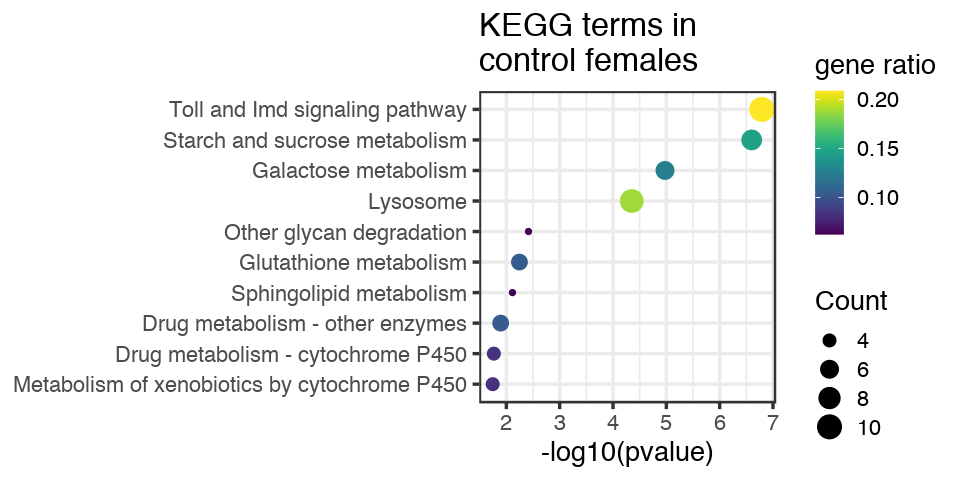

In [81]:
myKEGG <- as.data.frame(filter(virgins_kegg@result, qvalue < 0.05))
myKEGG$DEset = as.numeric(gsub(".*\\/", "", myKEGG$GeneRatio))
myKEGG$`gene ratio` = myKEGG$Count/myKEGG$DEset

options(repr.plot.width = 8, repr.plot.height = 4)
ggplot(myKEGG, aes(reorder(Description, -pvalue), -log10(pvalue),colour = `gene ratio`, size  = Count)) +    geom_point() +
 coord_flip() +
scale_colour_viridis() +
theme(axis.title.y = element_blank()) +
labs(title = "KEGG terms in\ncontrol females")

Do the Gene set enrichment analysis (GSEA), in'it?

In [82]:
as_tibble(lrt.mated.table) %>% 
    filter(gene %!in% mm_genes) %>% 
    rename(FBgn_ID = gene)  %>% 
    left_join(Entrez_mappings, by = "FBgn_ID")  %>% 
    select(ent_id, logFC) %>% 
    unique() %>% 
    arrange(desc(logFC)) %>% 
    deframe() ->
    geneList

geneList <- geneList[!duplicated(geneList)]

mated.gsea.bp <- gseGO(geneList     = geneList,
              OrgDb        = org.Dm.eg.db,
              ont          = "BP",
              nPerm        = 100000,
              minGSSize    = 50,
              maxGSSize    = 500,
              pvalueCutoff = 0.05,
              verbose      = TRUE)
head(mated.gsea.bp)

preparing geneSet collections...

GSEA analysis...

Warning message in fgsea(pathways = geneSets, stats = geneList, nperm = nPerm, minSize = minGSSize, :
"There are duplicate gene names, fgsea may produce unexpected results"
leading edge analysis...

done...



,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalues,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GO:0002376,GO:0002376,immune system process,335,0.4877235,1.902263,1.044277e-05,0.0008698699,0.0006975884,898,"tags=18%, list=12%, signal=17%",37183/317900/37184/36484/36636/36708/36635/43596/43597/36637/35861/43599/39870/33386/42644/3772367/36047/38244/43598/41379/36775/33226/39536/38858/12798556/34790/35862/40164/47457/42850/37084/32256/39063/42501/32051/37187/44054/40081/37099/33649/40378/35859/35834/32648/49045/50209/38891/32976/35877/39610/32099/41085/33576/31717/35045/5740170/38821/41670/39645/40660/7354421
GO:0009607,GO:0009607,response to biotic stimulus,298,0.5174064,2.003654,1.055342e-05,0.0008698699,0.0006975884,975,"tags=21%, list=13%, signal=19%",37183/317900/37184/36484/36636/3772138/36708/36635/43596/43597/36637/326136/35861/43599/39870/33386/38408/42644/36047/38153/43598/41379/33226/34813/32821/38858/12798556/34790/35862/42850/39063/42501/39978/32051/44054/37099/33592/40378/35859/39078/35834/41419/32648/49045/50209/36891/35524/32976/34636/35877/39610/32099/35045/5740170/38821/41670/40660/7354421/41829/42672/33078/34805
GO:0043207,GO:0043207,response to external biotic stimulus,298,0.5174064,2.003654,1.055342e-05,0.0008698699,0.0006975884,975,"tags=21%, list=13%, signal=19%",37183/317900/37184/36484/36636/3772138/36708/36635/43596/43597/36637/326136/35861/43599/39870/33386/38408/42644/36047/38153/43598/41379/33226/34813/32821/38858/12798556/34790/35862/42850/39063/42501/39978/32051/44054/37099/33592/40378/35859/39078/35834/41419/32648/49045/50209/36891/35524/32976/34636/35877/39610/32099/35045/5740170/38821/41670/40660/7354421/41829/42672/33078/34805
GO:0051707,GO:0051707,response to other organism,298,0.5174064,2.003654,1.055342e-05,0.0008698699,0.0006975884,975,"tags=21%, list=13%, signal=19%",37183/317900/37184/36484/36636/3772138/36708/36635/43596/43597/36637/326136/35861/43599/39870/33386/38408/42644/36047/38153/43598/41379/33226/34813/32821/38858/12798556/34790/35862/42850/39063/42501/39978/32051/44054/37099/33592/40378/35859/39078/35834/41419/32648/49045/50209/36891/35524/32976/34636/35877/39610/32099/35045/5740170/38821/41670/40660/7354421/41829/42672/33078/34805
GO:0006952,GO:0006952,defense response,293,0.5218648,2.018847,1.057138e-05,0.0008698699,0.0006975884,898,"tags=19%, list=12%, signal=18%",37183/317900/37184/36484/36636/3772138/36708/36635/43596/43597/36637/326136/35861/43599/39870/33386/38408/42644/36047/38153/43598/41379/36775/34813/39536/38858/12798556/34790/35862/42850/32256/39063/39978/32051/53554/44054/37099/40378/35859/39078/35834/41419/32648/49045/50209/36891/35524/32976/34636/35877/32099/35045/5740170/38821/41670/40660/7354421
GO:0098542,GO:0098542,defense response to other organism,232,0.5698375,2.169283,1.082521e-05,0.0008698699,0.0006975884,898,"tags=23%, list=12%, signal=21%",37183/317900/37184/36484/36636/3772138/36708/36635/43596/43597/36637/326136/35861/43599/39870/33386/38408/42644/36047/38153/43598/41379/34813/38858/12798556/34790/35862/42850/39063/39978/32051/44054/37099/40378/35859/39078/35834/41419/32648/49045/50209/36891/35524/32976/34636/35877/32099/35045/5740170/38821/41670/40660/7354421


In [83]:
as_tibble(lrt.mated.table) %>% 
    filter(gene %!in% mm_genes) %>%
    rename(FBgn_ID = gene)  %>% 
    left_join(Entrez_mappings, by = "FBgn_ID")  %>% 
    select(ent_id, logFC) %>% 
    unique() %>% 
    arrange(desc(logFC)) %>% 
    deframe() ->
    geneList

geneList <- geneList[!duplicated(geneList)]

mated.gsea.mf <- gseGO(geneList     = geneList,
              OrgDb        = org.Dm.eg.db,
              ont          = "MF",
              nPerm        = 100000,
              minGSSize    = 50,
              maxGSSize    = 500,
              pvalueCutoff = 0.01,
              verbose      = TRUE)
head(mated.gsea.mf)

preparing geneSet collections...

GSEA analysis...

Warning message in fgsea(pathways = geneSets, stats = geneList, nperm = nPerm, minSize = minGSSize, :
"There are duplicate gene names, fgsea may produce unexpected results"
leading edge analysis...

done...



,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalues,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>
GO:0004553,GO:0004553,"hydrolase activity, hydrolyzing O-glycosyl compounds",60,0.6400695,2.072152,5.222887e-05,0.007056908,0.006904532,656,"tags=28%, list=9%, signal=26%",42796/36863/35827/35826/34206/35829/35825/34203/34205/35824/31630/35830/49815/246565/47764/34714/36891
GO:0016798,GO:0016798,"hydrolase activity, acting on glycosyl bonds",65,0.6249598,2.048056,9.047317e-05,0.007056908,0.006904532,656,"tags=26%, list=9%, signal=24%",42796/36863/35827/35826/34206/35829/35825/34203/34205/35824/31630/35830/49815/246565/47764/34714/36891


In [84]:
hydrolases_of_mating <- as.character(unique(strsplit(as.data.frame(mated.gsea.mf)$core_enrichment, "\\/")))

In [85]:
write.table(as.data.frame(mated.gsea.bp), "Results/Tables/GSEA_mated_contrasts.txt", quote = F, sep = "\t")

Plot those results:

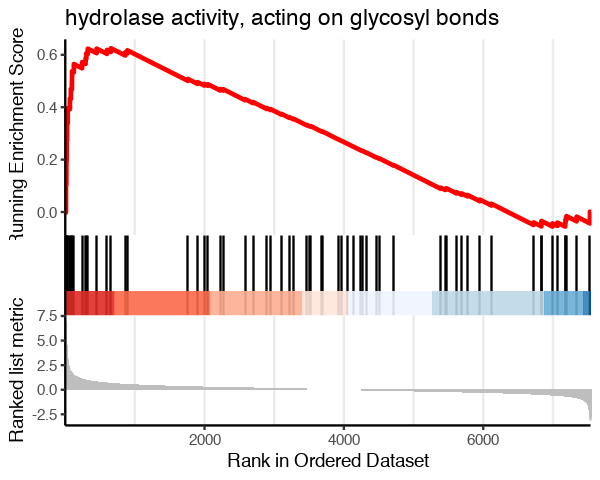

In [86]:
options(repr.plot.width = 5, repr.plot.height = 4)
# pdf("Results/Figures/MF_mated_GSEA.pdf", width = 5, height = 4.5)
gseaplot2(mated.gsea.mf, geneSetID = 2, title = mated.gsea.mf$Description[2], color = "red")
# dev.off()

In [87]:
fig3c_genes <- c("Bx", "Atpalpha", "Catsup", "Fer2", "Obp44a", "Nplp3", "Obp56g", "Rh5", "Pdf", "Capa", "ninaA", "ninaC", "trp", "Obp8a", "Obp57c")

In [88]:
heatmap_tmp <- function (tpmTable, gene_list, title) 
{   
    # Overwrite default draw_colnames in the pheatmap package.
# Thanks to Josh O'Brien at http://stackoverflow.com/questions/15505607
draw_colnames_45 <- function (coln, gaps, ...) {
    coord <- pheatmap:::find_coordinates(length(coln), gaps)
    x     <- coord$coord - 0.5 * coord$size
    res   <- grid::textGrob(
      coln, x = x, y = unit(1, "npc") - unit(3,"bigpts"),
      vjust = 0.75, hjust = 1, rot = 45, gp = grid::gpar(...)
    )
    return(res)
}
assignInNamespace(
  x = "draw_colnames",
  value = "draw_colnames_45",
  ns = asNamespace("pheatmap")
)
    col_annot = unique(select(sampleInfo, Sample, Status, Female))
    rownames(col_annot) = col_annot$Sample
    
    col_annot = subset(col_annot, select = c("Status", "Female"))
    cor_colors <- list(Female = c("#58b8f0","#ccae50"), Status = c("#feb0a4","#8cd253"))
    names(cor_colors$Female) <- unique(col_annot$Female)
    names(cor_colors$Status) <- unique(col_annot$Status)
    tmpMat <- cast(subset(tpmTable, gene_symbol %in% gene_list), 
        gene_id ~ Sample, value = "TPM", fun.aggregate = mean)
    data <- tmpMat[, -1]
    rownames(data) <- tmpMat[, 1]
    data = log2(data + 1)
    data = as.data.frame(t(scale(t(data), scale = F)))
    data[data < -1] = -1
    data[data > 1] = 1
    init_cols = colnames(data)
    data$FBgn_ID = rownames(data)
    data = merge(data, FBgn_to_symbol, by.x = "FBgn_ID", by.y = "primary_FBgn", 
        all.x = T)
    rownames(data) = data$gene_symbol
    data = subset(data, select = init_cols)
    colnames(data) = gsub("_", " ", colnames(data))
    p <- pheatmap(mat = data, main = title, color = inferno(100), 
        border_color = NA, show_colnames = TRUE, show_rownames = TRUE, 
        annotation_col = col_annot, drop_levels = TRUE, annotation_names_row = F, annotation_colors = cor_colors,
        fontsize = 8)
    return(p)
}

In [89]:
tmpMat <- cast(subset(tpm.table.rc, gene_symbol %in% fig3c_genes), 
        gene_id ~ Sample, value = "TPM", fun.aggregate = mean)

In [90]:
options(repr.plot.width = 5, repr.plot.height = 4)
# Overwrite default draw_colnames in the pheatmap package.
# Thanks to Josh O'Brien at http://stackoverflow.com/questions/15505607
draw_colnames_45 <- function (coln, gaps, ...) {
    coord <- pheatmap:::find_coordinates(length(coln), gaps)
    x     <- coord$coord - 0.5 * coord$size
    res   <- grid::textGrob(
      coln, x = x, y = unit(1, "npc") - unit(3,"bigpts"),
      vjust = 0.75, hjust = 1, rot = 45, gp = grid::gpar(...)
    )
    return(res)
}
assignInNamespace(
  x = "draw_colnames",
  value = "draw_colnames_45",
  ns = asNamespace("pheatmap")
)
    col_annot = unique(select(sampleInfo, Sample, Status, Female))
    rownames(col_annot) = col_annot$Sample
    
    col_annot = subset(col_annot, select = c("Status", "Female"))
    cor_colors <- list(Female = c("#58b8f0","#ccae50"), Status = c("#feb0a4","#8cd253"))
    names(cor_colors$Female) <- unique(col_annot$Female)
    names(cor_colors$Status) <- unique(col_annot$Status)
    tmpMat <- cast(subset(tpm.table.rc, gene_symbol %in% fig3c_genes), 
        gene_id ~ Sample, value = "TPM", fun.aggregate = mean)
    data <- tmpMat[, -1]
    rownames(data) <- tmpMat[, 1]
    data = log2(data + 1)
    data = as.data.frame(t(scale(t(data), scale = F)))
    data[data < -1] = -1
    data[data > 1] = 1
    init_cols = colnames(data)
    data$FBgn_ID = rownames(data)
    data = merge(data, FBgn_to_symbol, by.x = "FBgn_ID", by.y = "primary_FBgn", 
        all.x = T)
    rownames(data) = data$gene_symbol
    data = subset(data, select = init_cols)
    colnames(data) = gsub("_", " ", colnames(data))
    p <- pheatmap(mat = data, main = "", color = inferno(100), 
        border_color = NA, show_colnames = TRUE, show_rownames = TRUE, 
        annotation_col = col_annot, drop_levels = TRUE, annotation_names_row = F, annotation_colors = cor_colors, 
  filename          = "Results/manuscript_figures/fig_3C.pdf",
  width             = 5, 
  height            = 4,
  fontsize          = 12 )
    return(p)

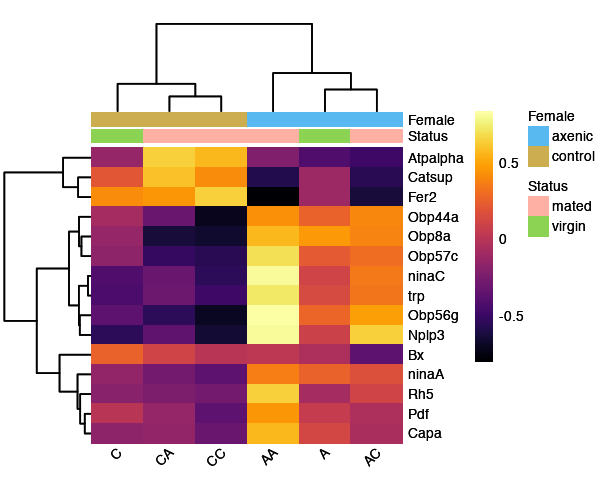

In [91]:
heatmap_tmp(tpm.table.rc, gene_list = fig3c_genes, title = "")

Output all individual gene plots for the virgin contrasts:

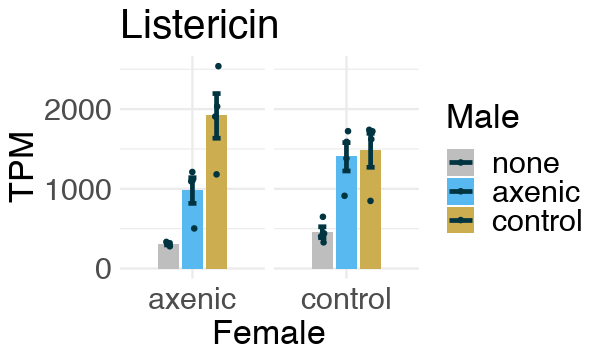

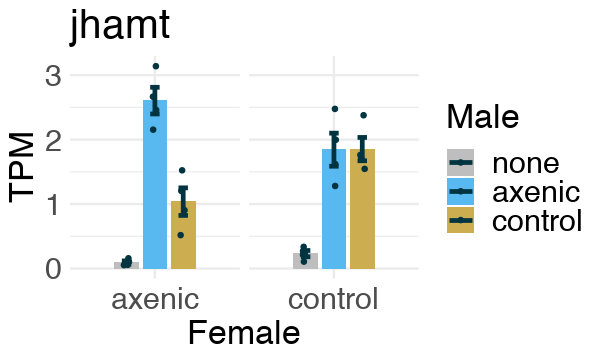

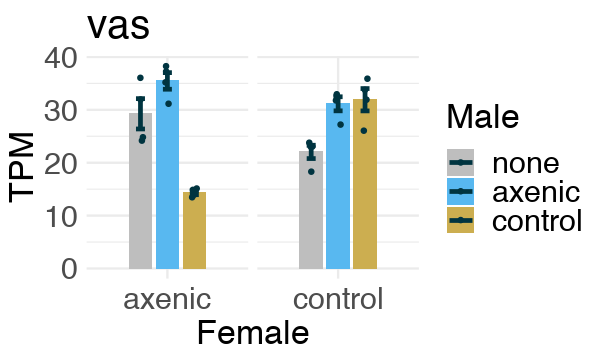

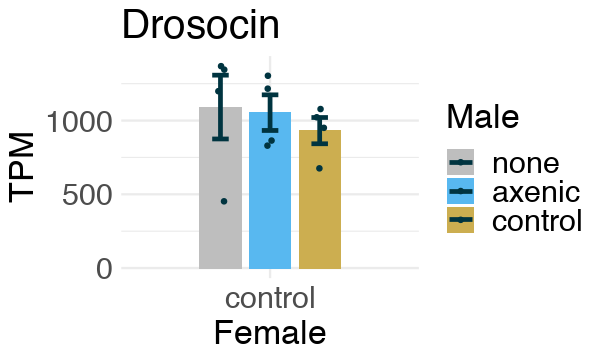

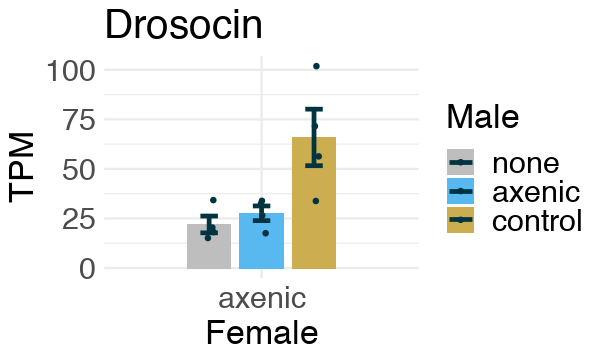

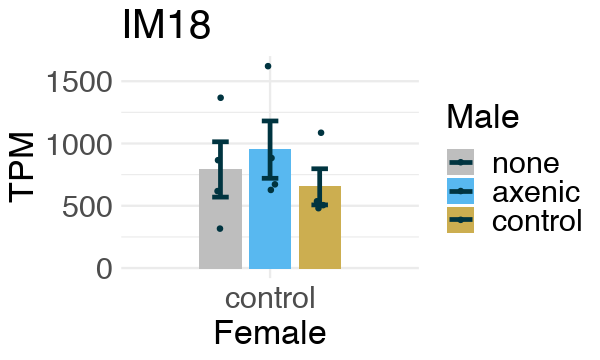

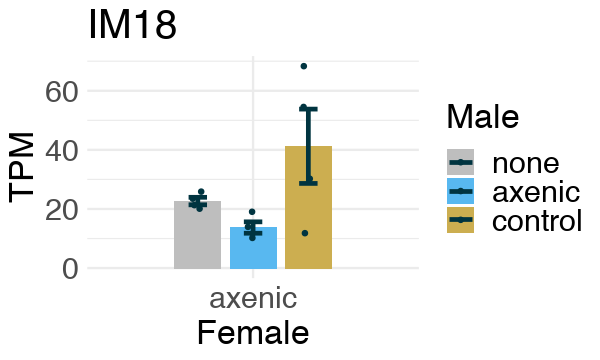

In [92]:
options(repr.plot.width = 5, repr.plot.height = 3)
listericin <- geneBarPlot(tpm.table.rc, "Listericin", show_reps = T) +
    labs(title = "Listericin", subtitle = NULL) +
    theme_minimal() +
    theme(axis.text = element_text(size = 18),
         axis.title = element_text(size = 20),
         strip.text = element_blank(), 
         plot.title = element_text(size = 24),
         legend.text = element_text(size = 18),
         legend.title = element_text(size = 20)) +
    ggsave("Results/manuscript_figures/listericin.pdf", height = 3, width = 5)

jhamt <- geneBarPlot(tpm.table.rc, "jhamt", show_reps = T) +
    labs(title = "jhamt", subtitle = NULL, size = 15) +
    theme_minimal() +
    theme(axis.text = element_text(size = 18),
         axis.title = element_text(size = 20),
         strip.text = element_blank(), 
         plot.title = element_text(size = 24),
         legend.text = element_text(size = 18),
         legend.title = element_text(size = 20))+
    ggsave("Results/manuscript_figures/jhamt.pdf", height = 3, width = 5)

vas <- geneBarPlot(tpm.table.rc, "vas", show_reps = T) +
    labs(title = "vas", subtitle = NULL) +
    theme_minimal() +
    theme(axis.text = element_text(size = 18),
         axis.title = element_text(size = 20),
         strip.text = element_blank(), 
         plot.title = element_text(size = 24),
         legend.text = element_text(size = 18),
         legend.title = element_text(size = 20))+
    ggsave("Results/manuscript_figures/vas.pdf", height = 3, width = 5)

Drosocin_ax <- geneBarPlot_byFemale(tpm.table.rc, "Dro", show_reps = T) +
    labs(title = "Drosocin", subtitle = NULL, size = 15) +
    theme_minimal() +
    theme(axis.text = element_text(size = 18),
         axis.title = element_text(size = 20),
         strip.text = element_blank(), 
         plot.title = element_text(size = 24),
         legend.text = element_text(size = 18),
         legend.title = element_text(size = 20))+
    ggsave("Results/manuscript_figures/dro_a.pdf", height = 3, width = 4)

IM18_ax <- geneBarPlot_byFemale(tpm.table.rc, "IM18", show_reps = T) +
    labs(title = "IM18", subtitle = NULL) +
    theme_minimal() +
    theme(axis.text = element_text(size = 18),
         axis.title = element_text(size = 20),
         strip.text = element_blank(), 
         plot.title = element_text(size = 24),
         legend.text = element_text(size = 18),
         legend.title = element_text(size = 20))+
    ggsave("Results/manuscript_figures/im18_a.pdf", height = 3, width = 4)

Drosocin_c <- geneBarPlot_byFemale(tpm.table.rc, "Dro", show_reps = T, female = "control") +
    labs(title = "Drosocin", subtitle = NULL, size = 15) +
    theme_minimal() +
    theme(axis.text = element_text(size = 18),
         axis.title = element_text(size = 20),
         strip.text = element_blank(), 
         plot.title = element_text(size = 24),
         legend.text = element_text(size = 18),
         legend.title = element_text(size = 20))+
    ggsave("Results/manuscript_figures/dro_c.pdf", height = 3, width = 4)

IM18_c <- geneBarPlot_byFemale(tpm.table.rc, "IM18", show_reps = T, female = "control") +
    labs(title = "IM18", subtitle = NULL) +
    theme_minimal() +
    theme(axis.text = element_text(size = 18),
         axis.title = element_text(size = 20),
         strip.text = element_blank(), 
         plot.title = element_text(size = 24),
         legend.text = element_text(size = 18),
         legend.title = element_text(size = 20))+
    ggsave("Results/manuscript_figures/im18_c.pdf", height = 3, width = 4)

listericin
jhamt
vas
Drosocin_c
Drosocin_ax
IM18_c
IM18_ax

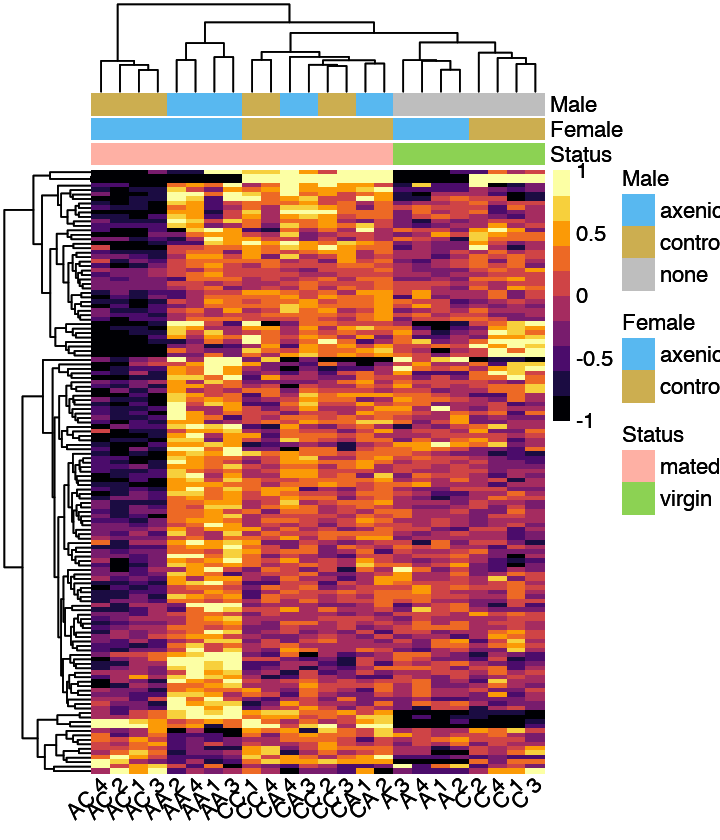

In [93]:
col_annot = unique(select(sampleInfo, Replicate, Status, 
            Female, Male))

cor_colors <- list(Female = c("#58b8f0","#ccae50"), Status = c("#feb0a4","#8cd253"), Male = c("#58b8f0","#ccae50","gray"))
names(cor_colors$Female) <- unique(col_annot$Female)
names(cor_colors$Male) <- unique(col_annot$Male)
names(cor_colors$Status) <- unique(col_annot$Status)

        rownames(col_annot) = col_annot$Replicate
        rownames(col_annot) = gsub("_", " ", rownames(col_annot))
        col_annot = subset(col_annot, select = c("Status", "Female", 
            "Male"))

data = subset(tpm_bt2_fixed, rownames(tpm_bt2_fixed) %in% AC.v.AA_sigGenes)
    data = log2(data + 1)
    data = as.data.frame(t(scale(t(data), scale = F)))
    data[data < -1] = -1
    data[data > 1] = 1
    init_cols = colnames(data)
    data$FBgn_ID = rownames(data)
    data = merge(data, FBgn_to_symbol, by.x = "FBgn_ID", by.y = "primary_FBgn", 
        all.x = T)
    rownames(data) = data$gene_symbol
    data = subset(data, select = init_cols)
    colnames(data) = gsub("_", " ", colnames(data))

options(repr.plot.width = 6, repr.plot.height = 7)
    p <- pheatmap(mat = data,
#                   main = title,
                  color = inferno(10),
                  border_color = NA,
                  show_colnames = TRUE,
                  show_rownames = FALSE,
                  annotation_col = col_annot,
                  annotation_colors = cor_colors,
                  drop_levels = TRUE,
                  annotation_names_row = F,
#                    filename          = "Results/manuscript_figures/AC.v.AA_sigGenes_heatmap.pdf",
#   width             = 6, 
#   height            = 7,
                 fontsize = 13,)
    return(p)

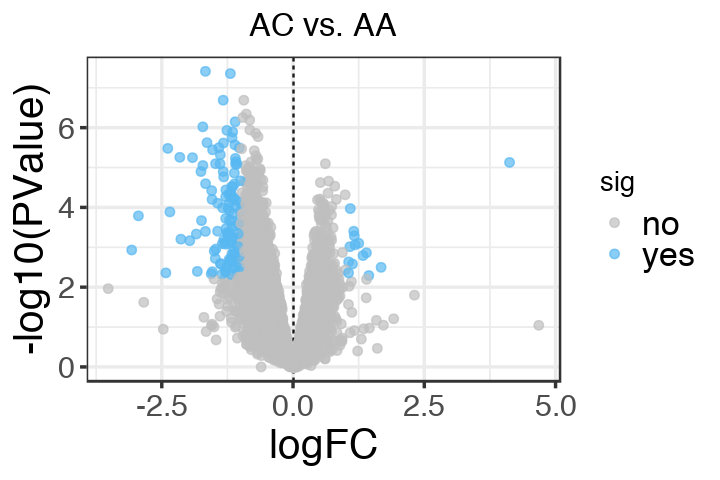

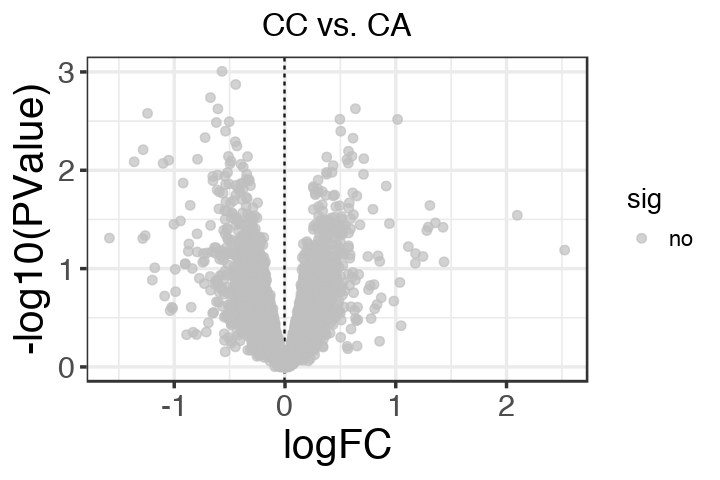

In [94]:
options(repr.plot.width = 6, repr.plot.height = 4)
ggplot(filter(lrt.AC.v.AA.table, gene %!in% mm_genes), aes(logFC, -log10(PValue), colour = sig)) +
       geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.9, colour = "black") +
       geom_point(alpha = 0.7, size = 2) +
       scale_colour_manual(values = c("grey","#58b8f0")) +
#                                 geom_label_repel(data = filter(lrt.AC.v.AA.table, sig == "yes" & gene %in% immunity_genes),aes(label=gene_symbol), 
#                                 force = 30,
#                                 fontface = "bold", 
#                                 size = 3,
# #                                 ylim = c(6, NA),
#                                 colour = "#006294") +
                                labs(title = "AC vs. AA", size = 2) +
#                                 theme_black_full() +
                                theme(axis.text = element_text(size = 18),
                                      axis.title = element_text(size = 24),
                                      plot.title = element_text(hjust = 0.5),
                                    legend.text = element_text(size = 20)) +
    ggsave("Results/manuscript_figures/AC.v.AA_volcano.pdf", height = 4, width = 6)

ggplot(filter(lrt.CC.v.CA.table, gene %!in% mm_genes), aes(logFC, -log10(PValue), colour = sig)) +
       geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.9, colour = "black") +
       geom_point(alpha = 0.7, size = 2) +
       scale_colour_manual(values = c("grey","#58b8f0")) +
#                                 geom_label_repel(data = filter(lrt.AC.v.AA.table, sig == "yes" & gene %in% immunity_genes),aes(label=gene_symbol), 
#                                 force = 30,
#                                 fontface = "bold", 
#                                 size = 3,
# #                                 ylim = c(6, NA),
#                                 colour = "#006294") +
                                labs(title = "CC vs. CA", size = 2) +
#                                 theme_black_full() +
                                theme(axis.text = element_text(size = 18),
                                      axis.title = element_text(size = 24),
                                      plot.title = element_text(hjust = 0.5)) +
    ggsave("Results/manuscript_figures/CC.v.CA_volcano.pdf", height = 4, width = 6)


In [95]:
# virgins_sigGenes.Plots = suppressMessages(lapply(virgins_sigGenes, geneBarPlot_mon, tpmTable = tpm.table.rc, show_reps = F))
# ggsave("Results/Figures/virgins_sigGenes.barPlots.pdf", marrangeGrob(grobs = virgins_sigGenes.Plots, nrow = 2, ncol =2))

And output snapshot summary:

In [96]:
# tempInfo = filter(snapshots, FBgn_ID %in% virgins_sigGenes)
# tempInfo = select(tempInfo, -datestamp)
# write.table(tempInfo, "Results/Tables/virgins_sigGenes_snapshots.txt", quote = F, sep = "\t", row.names = F)
# rm(tempInfo)

Output Tissue enrichment plots:

In [97]:

enrich_fa2_female <- data.frame(gene = rownames(tpm.matrix_fa2.female),
                AP = (tpm.matrix_fa2.female$Female_Anal_Pad)+2/tpm.matrix_fa2.female$Female_whole_flies,
                Crop = (tpm.matrix_fa2.female$Female_Crop)+2/tpm.matrix_fa2.female$Female_whole_flies,
               SG = (tpm.matrix_fa2.female$Female_Salivary_Gland)+2/tpm.matrix_fa2.female$Female_whole_flies,
               Midgut = (tpm.matrix_fa2.female$Female_Midgut)+2/tpm.matrix_fa2.female$Female_whole_flies,
               Hindgut = (tpm.matrix_fa2.female$Female_Hindgut)+2/tpm.matrix_fa2.female$Female_whole_flies,
               Tubule = (tpm.matrix_fa2.female$Female_Tubule)+2/tpm.matrix_fa2.female$Female_whole_flies,
               Brain = (tpm.matrix_fa2.female$Female_Brain)+2/tpm.matrix_fa2.female$Female_whole_flies,
               Eye = (tpm.matrix_fa2.female$Female_Eye)+2/tpm.matrix_fa2.female$Female_whole_flies,
               Head = (tpm.matrix_fa2.female$Female_Head)+2/tpm.matrix_fa2.female$Female_whole_flies,
               TAG = (tpm.matrix_fa2.female$Female_Thoracicoabdominal_Ganglion)+2/tpm.matrix_fa2.female$Female_whole_flies,
               "SP (V)"= (tpm.matrix_fa2.female$Female_Virgin_Spermatheca)+2/tpm.matrix_fa2.female$Female_whole_flies,
               "SP (M)"= (tpm.matrix_fa2.female$Female_Mated_Spermatheca)+2/tpm.matrix_fa2.female$Female_whole_flies,
               Ovaries = (tpm.matrix_fa2.female$Ovary)+2/tpm.matrix_fa2.female$Female_whole_flies,
               Carcass = (tpm.matrix_fa2.female$Female_Carcass)+2/tpm.matrix_fa2.female$Female_whole_flies)
enrich_fa2_female <- column_to_rownames(enrich_fa2_female, var = "gene")

enrich_fa2_core <- enrich_fa2_female[rownames(enrich_fa2_female) %in% micRes_elements$`virgin,mated`,]
enrich_fa2_core <- t(enrich_fa2_core)
enrich_fa2_core <- as.matrix(t(scale(enrich_fa2_core)))
enrich_fa2_core <- enrich_fa2_core[rowSums(is.na(enrich_fa2_core)) != ncol(enrich_fa2_core), ]
enrich_fa2_core <- as.data.frame(enrich_fa2_core) %>% rename(`SP (V)` = SP..V., `SP (M)` = SP..M.)

enrich_fa2_mated <- enrich_fa2_female[rownames(enrich_fa2_female) %in% micRes_elements$mated,]
enrich_fa2_mated <- t(enrich_fa2_mated)
enrich_fa2_mated <- as.matrix(t(scale(enrich_fa2_mated)))
enrich_fa2_mated <- enrich_fa2_mated[rowSums(is.na(enrich_fa2_mated)) != ncol(enrich_fa2_mated), ]
enrich_fa2_mated <- as.data.frame(enrich_fa2_mated) %>% rename(`SP (V)` = SP..V., `SP (M)` = SP..M.)

In [98]:
enrich_fa2_maleRes <- enrich_fa2_female[rownames(enrich_fa2_female) %in% AC.v.AA_sigGenes,]
enrich_fa2_maleRes <- t(enrich_fa2_maleRes)
enrich_fa2_maleRes <- as.matrix(t(scale(enrich_fa2_maleRes)))
enrich_fa2_maleRes <- enrich_fa2_maleRes[rowSums(is.na(enrich_fa2_maleRes)) != ncol(enrich_fa2_maleRes), ]
enrich_fa2_maleRes <- as.data.frame(enrich_fa2_maleRes) %>% rename(`SP (V)` = SP..V., `SP (M)` = SP..M.)

In [99]:
hydrolases_of_mating <- c("42796", "36863", "35827", "35826", "34206", "35829", "35825", "34203", "34205", "35824", "31630", "35830", "49815", "246565", "47764", "34714", "36891")

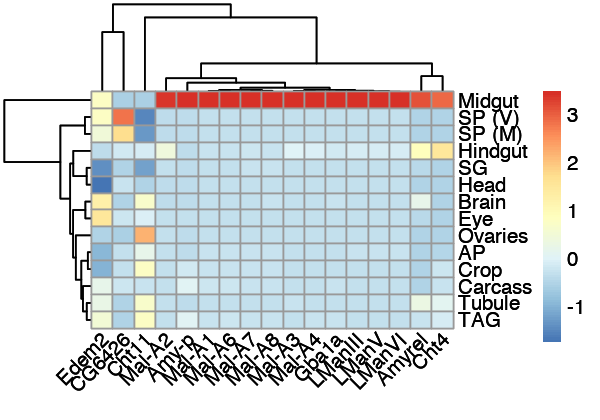

In [100]:
enrich_fa2_female <- data.frame(gene = rownames(tpm.matrix_fa2.female),
                AP = (tpm.matrix_fa2.female$Female_Anal_Pad)+2/tpm.matrix_fa2.female$Female_whole_flies,
                Crop = (tpm.matrix_fa2.female$Female_Crop)+2/tpm.matrix_fa2.female$Female_whole_flies,
               SG = (tpm.matrix_fa2.female$Female_Salivary_Gland)+2/tpm.matrix_fa2.female$Female_whole_flies,
               Midgut = (tpm.matrix_fa2.female$Female_Midgut)+2/tpm.matrix_fa2.female$Female_whole_flies,
               Hindgut = (tpm.matrix_fa2.female$Female_Hindgut)+2/tpm.matrix_fa2.female$Female_whole_flies,
               Tubule = (tpm.matrix_fa2.female$Female_Tubule)+2/tpm.matrix_fa2.female$Female_whole_flies,
               Brain = (tpm.matrix_fa2.female$Female_Brain)+2/tpm.matrix_fa2.female$Female_whole_flies,
               Eye = (tpm.matrix_fa2.female$Female_Eye)+2/tpm.matrix_fa2.female$Female_whole_flies,
               Head = (tpm.matrix_fa2.female$Female_Head)+2/tpm.matrix_fa2.female$Female_whole_flies,
               TAG = (tpm.matrix_fa2.female$Female_Thoracicoabdominal_Ganglion)+2/tpm.matrix_fa2.female$Female_whole_flies,
               "SP (V)"= (tpm.matrix_fa2.female$Female_Virgin_Spermatheca)+2/tpm.matrix_fa2.female$Female_whole_flies,
               "SP (M)"= (tpm.matrix_fa2.female$Female_Mated_Spermatheca)+2/tpm.matrix_fa2.female$Female_whole_flies,
               Ovaries = (tpm.matrix_fa2.female$Ovary)+2/tpm.matrix_fa2.female$Female_whole_flies,
               Carcass = (tpm.matrix_fa2.female$Female_Carcass)+2/tpm.matrix_fa2.female$Female_whole_flies)
enrich_fa2_female <- column_to_rownames(enrich_fa2_female, var = "gene")

enrich_fa2_hyrdo <- enrich_fa2_female[rownames(enrich_fa2_female) %in% filter(Entrez_mappings, ent_id %in% hydrolases_of_mating)$FBgn_ID,]
enrich_fa2_hyrdo <- rownames_to_column(enrich_fa2_hyrdo, var = "gene")
enrich_fa2_hyrdo <- merge(enrich_fa2_hyrdo, FBgn_to_symbol, by.x = "gene", by.y = "primary_FBgn", all.x = T)
enrich_fa2_hyrdo <- select(enrich_fa2_hyrdo, -gene)
enrich_fa2_hyrdo <- column_to_rownames(enrich_fa2_hyrdo, var = "gene_symbol")
enrich_fa2_hyrdo <- t(enrich_fa2_hyrdo)

enrich_fa2_hyrdo <- as.matrix(t(scale(enrich_fa2_hyrdo)))
enrich_fa2_hyrdo <- enrich_fa2_hyrdo[rowSums(is.na(enrich_fa2_hyrdo)) != ncol(enrich_fa2_hyrdo), ]
enrich_fa2_hyrdo <- as.data.frame(enrich_fa2_hyrdo) %>% rename(`SP (V)` = SP..V., `SP (M)` = SP..M.)

options(repr.plot.width = 5, repr.plot.height = 3.5)
p <- pheatmap(mat = t(enrich_fa2_hyrdo),
#                   main = "",
#                   color = inferno(10),
#                   border_color = NA,
                  show_colnames = TRUE,
                  show_rownames = TRUE,
#                   annotation_col = col_annot,
#                   annotation_colors = cor_colors,
                  drop_levels = TRUE,
#                   annotation_names_row = F,
#                    filename          = "Results/manuscript_figures/tissue_enrichment_mated__genes.pdf",
#   width             = 5, 
#   height            = 3.5,
                 fontsize = 12,)
    return(p)

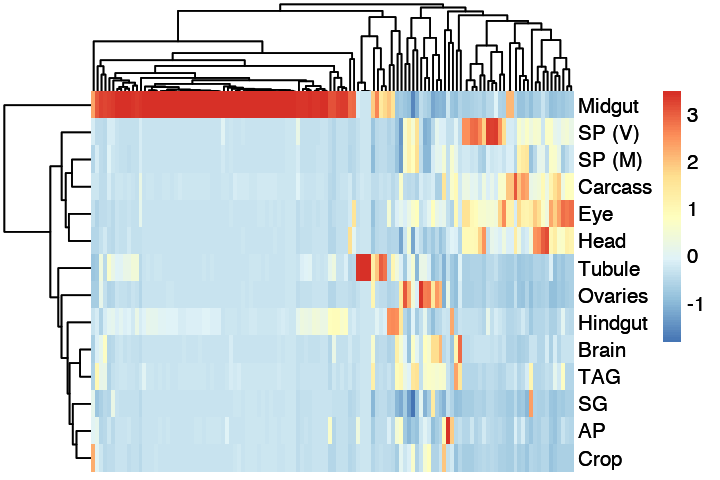

In [101]:
options(repr.plot.width = 6, repr.plot.height = 4)
p <- pheatmap(mat = t(enrich_fa2_core),
#                   main = "",
#                   color = inferno(10),
#                   border_color = NA,
                  show_colnames = FALSE,
                  show_rownames = TRUE,
#                   annotation_col = col_annot,
#                   annotation_colors = cor_colors,
                  drop_levels = TRUE,
#                   annotation_names_row = F,
#                    filename          = "Results/manuscript_figures/tissue_enrichment_core_genes.pdf",
#   width             = 6, 
#   height            = 4,
                 fontsize = 12,)
    return(p)

In [103]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS Mojave 10.14.6

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/3.6/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.6/Resources/lib/libRlapack.dylib

Random number generation:
 RNG:     Mersenne-Twister 
 Normal:  Inversion 
 Sample:  Rounding 
 
locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
 [1] grid      stats4    parallel  stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] viridis_0.5.1               viridisLite_0.3.0          
 [3] VennDiagram_1.6.20          futile.logger_1.4.3        
 [5] forcats_0.5.0               dplyr_1.0.0                
 [7] purrr_0.3.4                 readr_1.3.1                
 [9] tidyr_1.1.0                 tibble_3.0.1               
[11] tidyverse_1.3.0             sva_3.32.1               

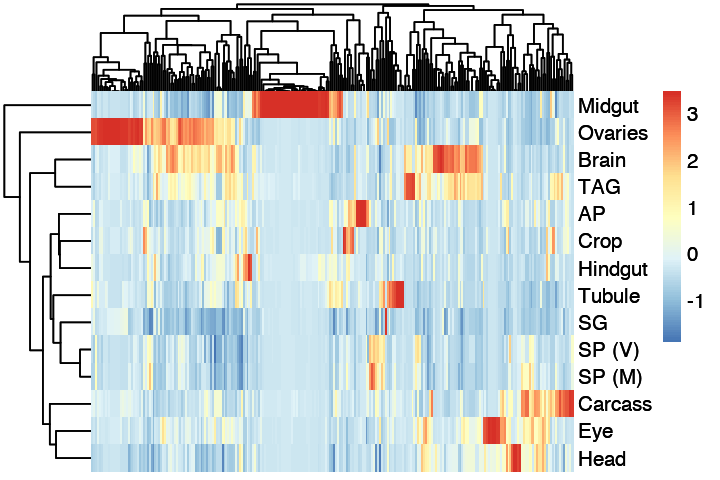

In [102]:
options(repr.plot.width = 6, repr.plot.height = 4)
p <- pheatmap(mat = t(enrich_fa2_mated),
#                   main = "",
#                   color = inferno(10),
#                   border_color = NA,
                  show_colnames = FALSE,
                  show_rownames = TRUE,
#                   annotation_col = col_annot,
#                   annotation_colors = cor_colors,
                  drop_levels = TRUE,
#                   annotation_names_row = F,
#                    filename          = "Results/manuscript_figures/tissue_enrichment_mating_genes.pdf",
#   width             = 6, 
#   height            = 4,
                 fontsize = 12,)
    return(p)